# Corpus Analysis of 20 Corporate Reports (2019) for Companies listed on Vienna Stock Exchange

In [1]:
!pip install -U -q nltk gensim wordcloud textract textstat textblob spacy pyldavis goose3

ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

pathy 0.5.2 requires smart-open<4.0.0,>=2.2.0, but you'll have smart-open 5.1.0 which is incompatible.
pyldavis 3.3.1 requires numpy>=1.20.0, but you'll have numpy 1.19.2 which is incompatible.


Installing packages

In [2]:
import os
import pathlib
import time
import codecs
import string
import re
from collections import Counter
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import urllib
import requests
from bs4 import BeautifulSoup

import nltk
import networkx as nx
import gensim
from wordcloud import WordCloud
import textract
import pyLDAvis
import pyLDAvis.gensim
import spacy
import textstat
import textblob

from IPython.core.display import Image
%matplotlib inline



Matplotlib is building the font cache; this may take a moment.
/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


ModuleNotFoundError: No module named 'pyLDAvis.gensim'

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/aroslava/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /Users/aroslava/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/aroslava/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aroslava/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /Users/aroslava/nltk_data...
[nltk_data]   U

True

Checking the files and their locations

In [4]:
datapath = "../Data/GB_txt"
outputs = "../Data/"

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
onlyfiles = [f for f in os.listdir(datapath) if os.path.isfile(os.path.join(datapath,f)) and not f.startswith('.')]
onlyfiles.sort()

print('Files in the folder:')
for i, w in enumerate(onlyfiles[0:]):
    print(i+1, '--' ,w)

Files in the folder:
1 -- 10_Scholler_Bleckmann.txt
2 -- 11_Erste.txt
3 -- 12_UNIQA.txt
4 -- 13_VA.txt
5 -- 14_VIG.txt
6 -- 15_Wienerberger.txt
7 -- 16_BAWAG.txt
8 -- 17_Post.txt
9 -- 18_OMV.txt
10 -- 19_SImmo.txt
11 -- 1_RBI.txt
12 -- 20_VERBUND.txt
13 -- 2_A1.txt
14 -- 3_Andritz.txt
15 -- 4_ATS.txt
16 -- 5_Immofinanz.txt
17 -- 6_MMKarton.txt
18 -- 7_DOCO.txt
19 -- 8_Lenzing.txt
20 -- 9_CAImmo.txt


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
raw_texts = ''

for filename in [f for f in onlyfiles if f.endswith('txt')]:
    print(filename)
    text = textract.process(os.path.join(datapath,filename)).decode('utf-8')
    print('\nText:\n', text[0:1200])
    raw_texts += '\n'+ text
    break

10_Scholler_Bleckmann.txt

Text:
 1

15
14
09

08

01

02

05
06
07
03
04
19
10

11

01

SCHOELLER-BLECKMANN
OILFIELD EQUIPMENT AG
TERNITZ, ÖSTERREICH

2

16 17
18

02

SCHOELLER-BLECKMANN OILFIELD
TECHNOLOGY GMBH
Ternitz, Österreich

03

KNUST-GODWIN LLC
Houston, USA

04

SCHOELLER-BLECKMANN SALES CO. L.L.C.
Houston, USA

05

THE WELLBOSS COMPANY, LLC
Houston, USA

06

BICO DRILLING TOOLS INC.
Houston, USA

07

SCHOELLER-BLECKMANN ENERGY
SERVICES L.L.C.
Broussard, USA

08

BICO FASTER DRILLING TOOLS INC.
Nisku, Kanada

09

THE WELLBOSS COMPANY, INC.
Calgary, Kanada

10

DSI PBL DE MEXICO, S.A. DE C.V.
Villahermosa, Mexiko

11

SCHOELLER BLECKMANN DO BRASIL LTDA.
Macae, Brasilien

12

KNUST-SBD PTE LTD.
Singapur

13

SCHOELLER-BLECKMANN OILFIELD
EQUIPMENT VIETNAM CO., LTD.
Binh Duong, Vietnam

13
12

V I E T N A M

14

SCHOELLER-BLECKMANN DARRON
(ABERDEEN) LTD.
Aberdeen, GB

15

SCHOELLER-BLECKMANN DARRON LTD.
Noyabrsk, Russland

16

SCHOELLER-BLECKMANN OILFIELD
EQUIPMENT MIDDLE EAST

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [15]:
print(len(raw_texts))

319114


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Clean texts out of punctuation signs

In [16]:
cleaned_texts = raw_texts.lower()
cleaned_texts = re.sub(' +',' ', cleaned_texts) #Remove multiple spaces
cleaned_texts = re.sub(r'\n\s*\n', '\n', cleaned_texts)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [17]:
print(len(cleaned_texts))

313941


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
print(cleaned_texts[0:1200])


1
15
14
09
08
01
02
05
06
07
03
04
19
10
11
01
schoeller-bleckmann
oilfield equipment ag
ternitz, österreich
2
16 17
18
02
schoeller-bleckmann oilfield
technology gmbh
ternitz, österreich
03
knust-godwin llc
houston, usa
04
schoeller-bleckmann sales co. l.l.c.
houston, usa
05
the wellboss company, llc
houston, usa
06
bico drilling tools inc.
houston, usa
07
schoeller-bleckmann energy
services l.l.c.
broussard, usa
08
bico faster drilling tools inc.
nisku, kanada
09
the wellboss company, inc.
calgary, kanada
10
dsi pbl de mexico, s.a. de c.v.
villahermosa, mexiko
11
schoeller bleckmann do brasil ltda.
macae, brasilien
12
knust-sbd pte ltd.
singapur
13
schoeller-bleckmann oilfield
equipment vietnam co., ltd.
binh duong, vietnam
13
12
v i e t n a m
14
schoeller-bleckmann darron
(aberdeen) ltd.
aberdeen, gb
15
schoeller-bleckmann darron ltd.
noyabrsk, russland
16
schoeller-bleckmann oilfield
equipment middle east fze
dubai, vae
17
dsi fze
dubai, vae
18
bico drilling tools fze
dubai, vae

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Clean stopwords and list the 20 most common lexemes

In [22]:
stopwords = nltk.corpus.stopwords.words('german')
list_words = cleaned_texts.split()
list_words = [l.strip().lower() for l in list_words]
list_words = [l.strip(string.punctuation+'“”’') for l in list_words]
list_words = [l for l in list_words if l not in stopwords]

freqdist = Counter(list_words)
freqdist.most_common(20)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('', 715),
 ('2019', 332),
 ('0', 291),
 ('2018', 241),
 ('konzernabschluss', 227),
 ('teur', 199),
 ('sbo', 188),
 ('meur', 140),
 ('dezember', 139),
 ('31', 133),
 ('sowie', 124),
 ('–', 120),
 ('erläuterung', 119),
 ('•', 115),
 ('1', 99),
 ('wurden', 97),
 ('jahr', 91),
 ('erläuterungen', 88),
 ('unternehmen', 84),
 ('steuern', 70)]

Search for expression

In [23]:
expression = 'Geld'
pos = 0 
positions = []

while pos != -1:
    position = cleaned_texts.find(expression,pos+1)
    pos = position
    positions.append(position)
positions.pop()
print('The expression is found {} times'.format(len(positions)))
print(positions)

The expression is found 0 times
[]


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [25]:
tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(cleaned_texts)
nltk_text = nltk.Text(tokens)

nltk_text.concordance(expression.lower(), width=1000, lines=100)

no matches


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
nltk_text.similar(expression)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


No matches


Search for collocations

In [27]:
nltk_text.collocation_list(num=20, window_size=20)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('erläuterungen', 'konzernabschluss'),
 ('000', '000'),
 ('2017', '2017'),
 ('zum', 'konzernabschluss'),
 ('2016', '2016'),
 ('schoeller', 'bleckmann'),
 ('meur', 'meur'),
 ('siehe', 'erläuterung'),
 ('absolut', 'absolut'),
 ('corporate', 'governance'),
 ('alter', 'absolut'),
 ('100', '100'),
 ('erläuterungen', 'zum'),
 ('zum', 'dezember'),
 ('absolut', 'männer'),
 ('well', 'completion'),
 ('fix', 'endfällig'),
 ('oilfield', 'equipment'),
 ('erklärung', 'nachhaltiges'),
 ('nichtfinanzielle', 'nachhaltiges')]

Print 30 bigrams

In [28]:
max_items = 30
freq_min_b = 10
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder2 = nltk.collocations.BigramCollocationFinder.from_words(nltk_text)
finder2.apply_word_filter(lambda w: w in string.punctuation)
finder2.apply_freq_filter(freq_min_b)
for a, b in finder2.nbest(bigram_measures.pmi, max_items):
    print(a, b)

gerald grohmann
darüber hinaus
beherrschenden anteilen
advanced manufacturing
norbert zimmermann
downhole technology
tel .:
the wellboss
wellboss company
beizulegenden zeitwert
rückwirkende anpassungen
completion technologies
well completion
nichtfinanzielle erklärung
.: (+
while drilling
resource well
corporate governance
governance kodex
pro aktie
bico drilling
endfällig eur
oilfield equipment
bleckmann darron
immaterielle vermögenswerte
tools inc
drilling tools
nachhaltiges management
governance bericht
latente steuern


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Print 30 trigrams

In [29]:
max_items = 30
freq_min_t = 6
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder3 = nltk.collocations.TrigramCollocationFinder.from_words(nltk_text)
finder3.apply_word_filter(lambda w: w in string.punctuation)
finder3.apply_ngram_filter(lambda w1, w2, w3:  w1 in ['da', 'de', 'das'])
finder3.apply_freq_filter(freq_min_t)
for a, b, c in finder3.nbest(trigram_measures.pmi, max_items):
    print(a, b, c)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


put -/ call
young wirtschaftsprüfungsgesellschaft m
code of conduct
international financial reporting
konsolidierung einbezogenen tochtergesellschaften
logging while drilling
the wellboss company
measurement while drilling
tel .: (+
„ quality first
well completion technologies
resource well completion
2017 2016 2015
bico drilling tools
kündbaren nicht beherrschenden
corporate governance kodex
„ advanced manufacturing
oilfield technology gmbh
nicht beherrschenden anteilen
completion technologies inc
zu fortgeführten anschaffungskosten
oilfield equipment aktiengesellschaft
segment „ advanced
drilling tools inc
corporate governance bericht
österreichischen corporate governance
– rückwirkende anpassungen
while drilling “
optionsverbindlichkeiten aus kündbaren
wie folgt dar


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


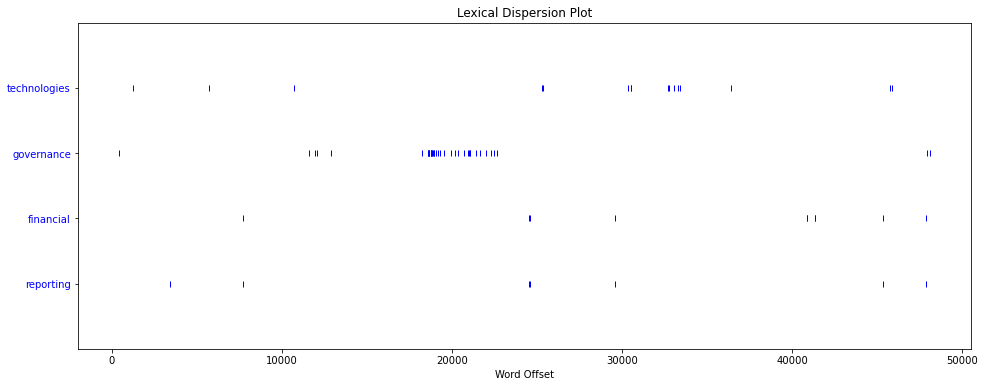

In [31]:
dispersion_words = ['technologies', 'governance', 'financial','reporting']
plt.figure(figsize=(16,6))
nltk_text.dispersion_plot(dispersion_words)

In [32]:
freqdist.most_common(100)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('', 715),
 ('2019', 332),
 ('0', 291),
 ('2018', 241),
 ('konzernabschluss', 227),
 ('teur', 199),
 ('sbo', 188),
 ('meur', 140),
 ('dezember', 139),
 ('31', 133),
 ('sowie', 124),
 ('–', 120),
 ('erläuterung', 119),
 ('•', 115),
 ('1', 99),
 ('wurden', 97),
 ('jahr', 91),
 ('erläuterungen', 88),
 ('unternehmen', 84),
 ('steuern', 70),
 ('vorjahr', 70),
 ('wurde', 70),
 ('sonstige', 69),
 ('siehe', 67),
 ('vermögenswerte', 67),
 ('geschäftsjahr', 66),
 ('ergebnis', 66),
 ('unserer', 65),
 ('gesellschaft', 65),
 ('eur', 60),
 ('summe', 60),
 ('höhe', 57),
 ('gemäß', 54),
 ('4', 53),
 ('forderungen', 53),
 ('verbindlichkeiten', 51),
 ('schoeller-bleckmann', 49),
 ('bzw', 49),
 ('kunden', 48),
 ('management', 47),
 ('oilfield', 46),
 ('20', 46),
 ('ifrs', 46),
 ('lagebericht', 45),
 ('2020', 45),
 ('jänner', 45),
 ('mitarbeiter', 44),
 ('2', 43),
 ('erfasst', 43),
 ('equipment', 42),
 ('drilling', 41),
 ('aufsichtsrat', 40),
 ('nachhaltiges', 38),
 ('folgt', 38),
 ('10', 37),
 ('16', 37

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


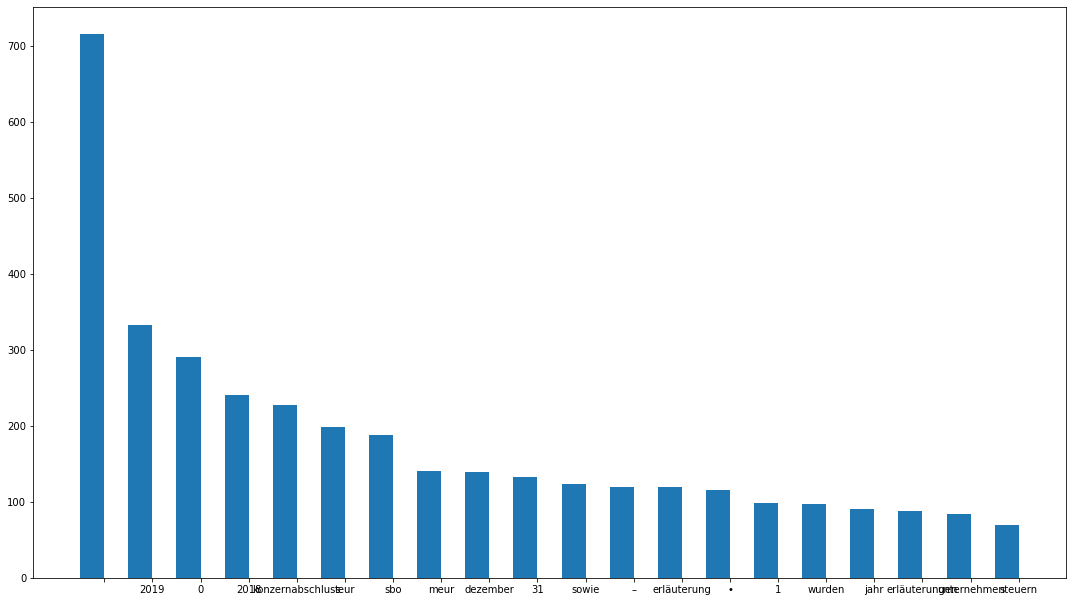

In [34]:
labels, values = zip(*freqdist.most_common(20))

indexes = np.arange(len(labels))
width = 0.5

plt.bar(indexes, values, width)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.xticks(indexes + width * 0.5, labels)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


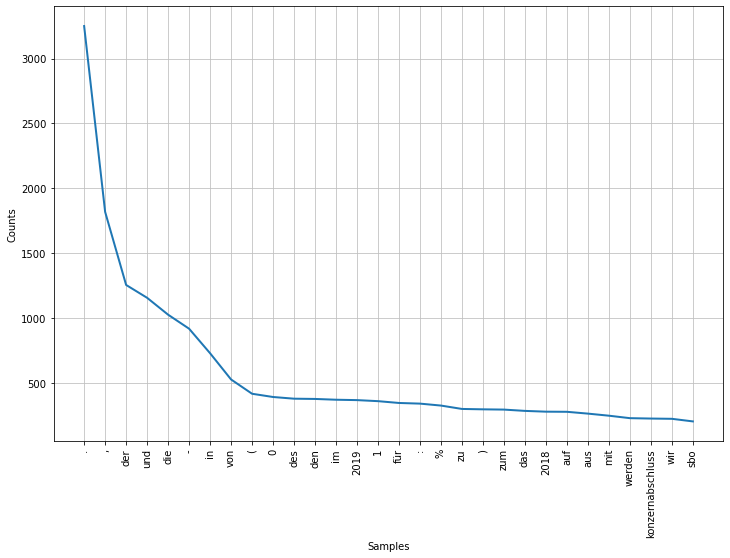

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [35]:
fd_words = nltk.FreqDist(tokens)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


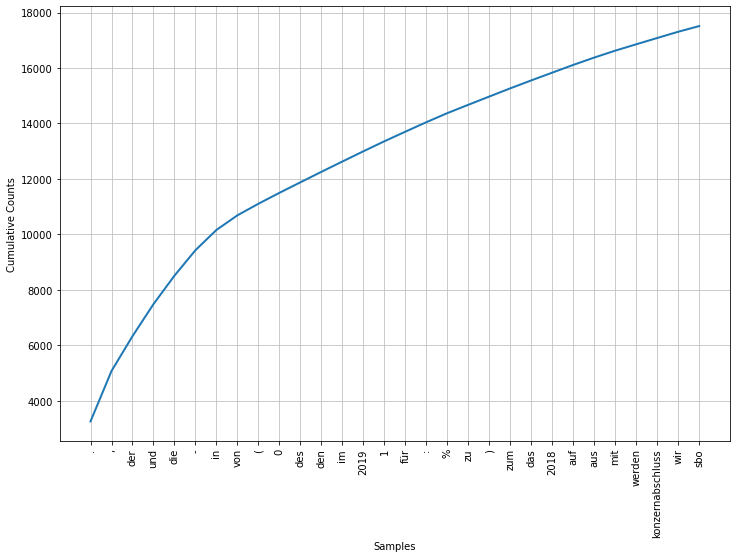

<AxesSubplot:xlabel='Samples', ylabel='Cumulative Counts'>

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30, cumulative = True)

Plotting histograms gone wrong – it seems I did not understand which object I need to use the function on. The apply method does not work neither on strings nor on lists or Texts.

In [62]:
nltk_texts.str.len().hist()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'nltk_texts' is not defined

In [45]:
cleaned_texts[0:].str.split().map(lambda x: len(x)).hist()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'str' object has no attribute 'str'

In [44]:
cleaned_texts[0:19].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'str' object has no attribute 'str'

In [46]:
#import nltk
#nltk.download('stopwords')
stop = set(nltk.corpus.stopwords.words('german'))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Creating a corpus in NLTK is also confusing to me. I tried to convert a text to string with join, but nothing has happened.

In [66]:
corpus=[]
nn = nltk_text.join()
new = nltk_text.split()
new = nn.values.tolist()
corpus = [word for i in new for word in i]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'Text' object has no attribute 'join'

In [51]:
dic = defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word] += 1
top = sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y = zip(*top)
plt.bar(x,y)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: not enough values to unpack (expected 2, got 0)

In [67]:
counter = Counter(corpus)
most = counter.most_common()

x, y = [], []
for word,count in most[:40]:
    if (word not in stop):
        x.append(word)
        y.append(count)
        
sns.barplot(x=y,y=x)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:250: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vals = pd.Series(vals, index=index)


ValueError: min() arg is an empty sequence

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [70]:
top_n_bigrams=get_top_ngram(cleaned_texts,2)[:10]
x,y = map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: Iterable over raw text documents expected, string object received.

In [71]:
top_tri_grams=get_top_ngram(cleaned_texts[0:19],n=3)
x,y = map(list,zip(*top_tri_grams))
sns.barplot(x=y,y=x)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: Iterable over raw text documents expected, string object received.

In [53]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def show_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)
   
    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(corpus)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ValueError: We need at least 1 word to plot a word cloud, got 0.

Textblob is a better and more efficient package in my opinion.

In [94]:
from textblob import TextBlob
from textblob import Word


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [115]:
blob = TextBlob(text)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [116]:
for s in blob.sentences:
    print(f'Sentence: {s} \n')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Sentence: 1

15
14
09

08

01

02

05
06
07
03
04
19
10

11

01

SCHOELLER-BLECKMANN
OILFIELD EQUIPMENT AG
TERNITZ, ÖSTERREICH

2

16 17
18

02

SCHOELLER-BLECKMANN OILFIELD
TECHNOLOGY GMBH
Ternitz, Österreich

03

KNUST-GODWIN LLC
Houston, USA

04

SCHOELLER-BLECKMANN SALES CO. L.L.C. 

Sentence: Houston, USA

05

THE WELLBOSS COMPANY, LLC
Houston, USA

06

BICO DRILLING TOOLS INC.
Houston, USA

07

SCHOELLER-BLECKMANN ENERGY
SERVICES L.L.C. 

Sentence: Broussard, USA

08

BICO FASTER DRILLING TOOLS INC.
Nisku, Kanada

09

THE WELLBOSS COMPANY, INC.
Calgary, Kanada

10

DSI PBL DE MEXICO, S.A. DE C.V.
Villahermosa, Mexiko

11

SCHOELLER BLECKMANN DO BRASIL LTDA. 

Sentence: Macae, Brasilien

12

KNUST-SBD PTE LTD.
Singapur

13

SCHOELLER-BLECKMANN OILFIELD
EQUIPMENT VIETNAM CO., LTD.
Binh Duong, Vietnam

13
12

V I E T N A M

14

SCHOELLER-BLECKMANN DARRON
(ABERDEEN) LTD.
Aberdeen, GB

15

SCHOELLER-BLECKMANN DARRON LTD.
Noyabrsk, Russland

16

SCHOELLER-BLECKMANN OILFIELD
EQUIPMENT

Sentence: Dezember 2018 waren Wertberichtigungen vorzunehmen. 

Sentence: Es
bestanden keine überfälligen Forderungen. 

Sentence: Zu den angeführten anderen Forderungen und Vermögenswerten wurden keine Sicherheiten erhalten. 

Sentence: 125

Erläuterungen zum Konzernabschluss | KONZERNABSCHLUSS

ERLÄUTERUNG 11
LATENTE STEUERN

Die aktiven und passiven latenten Steuerabgrenzungen resultieren aus den folgenden Positionen:

31.12.2019

in TEUR

31.12.2018

aktiv

passiv

aktiv

passiv

Sachanlagen

1.721

-6.698

1.359

-5.751

Sonstige Immaterielle Vermögenswerte (unterschiedliche
Nutzungsdauern)

1.685

-141

1.153

-167

Firmenwerte und sonstige Immaterielle Vermögenswerte
(unterschiedliche Wertansätze)

6.523

-8.047

0

-7.438

Vorräte (Bewertungsunterschiede)

6.531

-31

6.096

0

325

0

688

0

18.095

0

21.333

0

Sonstige Posten (Bewertungsunterschiede)

1.480

-513

1.862

-405

Rückstellungen

2.459

0

2.538

0

-72

0

-64

0

1.873

0

3.098

0

40.620

-15.430

38.063



Sentence: Pro Bohrloch
werden heute – je nach Bauart und Bohrloch – mitunter
mehr als 100 Frac Plugs eingesetzt. 

Sentence: DRILLED BUT UNCOMPLETED WELLS (DUCS)

FRAC PORT

Ein gebohrtes, aber noch nicht komplettiertes
Bohrloch bezeichnet ein Bohrloch nach dem
Ende des Bohrprozesses, bei dem der erste
Komplettierungsprozess aber noch nicht durchgeführt

Frac Port ist eine Innovation unter den Well CompletionTechnologien. 

Sentence: Beim Frac Port-Verfahren wird im
Unterschied zum Plug-n-Perf-Verfahren der Druck für

187

GLOSSAR

OPEC COMPLIANCE

das hydraulische Aufbrechen des Gesteins innerhalb
des Produktionsstranges aufgebaut und durch Öffnen
des Frac Port in das Gestein entladen. 

Sentence: Das Verfahren
weist somit eine höhere Effizienz als das Plug-n-PerfVerfahren auf. 

Sentence: OPEC Compliance stellt nach der Definition der
International Energy Agency (IEA) die von den
OPEC Staaten erstmals am 30. 

Sentence: November 2016 –
und in weiterer Folge – im Beschlusswege pro
M

In [117]:
blob.sentences[1].words

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


WordList(['Houston', 'USA', '05', 'THE', 'WELLBOSS', 'COMPANY', 'LLC', 'Houston', 'USA', '06', 'BICO', 'DRILLING', 'TOOLS', 'INC', 'Houston', 'USA', '07', 'SCHOELLER-BLECKMANN', 'ENERGY', 'SERVICES', 'L.L.C'])

In [118]:
blob.sentences[10].words.singularize()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


WordList(['verfügt', 'SBO', 'wie', 'kaum', 'ein', 'andere', 'Unternehman', 'der', 'Branche'])

In [119]:
blob.tags[0:10]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('1', 'CD'),
 ('15', 'CD'),
 ('14', 'CD'),
 ('09', 'CD'),
 ('08', 'CD'),
 ('01', 'CD'),
 ('02', 'CD'),
 ('05', 'CD'),
 ('06', 'CD'),
 ('07', 'CD')]

In [120]:
for ngram in blob.ngrams(2):
    print(ngram)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['1', '15']
['15', '14']
['14', '09']
['09', '08']
['08', '01']
['01', '02']
['02', '05']
['05', '06']
['06', '07']
['07', '03']
['03', '04']
['04', '19']
['19', '10']
['10', '11']
['11', '01']
['01', 'SCHOELLER-BLECKMANN']
['SCHOELLER-BLECKMANN', 'OILFIELD']
['OILFIELD', 'EQUIPMENT']
['EQUIPMENT', 'AG']
['AG', 'TERNITZ']
['TERNITZ', 'ÖSTERREICH']
['ÖSTERREICH', '2']
['2', '16']
['16', '17']
['17', '18']
['18', '02']
['02', 'SCHOELLER-BLECKMANN']
['SCHOELLER-BLECKMANN', 'OILFIELD']
['OILFIELD', 'TECHNOLOGY']
['TECHNOLOGY', 'GMBH']
['GMBH', 'Ternitz']
['Ternitz', 'Österreich']
['Österreich', '03']
['03', 'KNUST-GODWIN']
['KNUST-GODWIN', 'LLC']
['LLC', 'Houston']
['Houston', 'USA']
['USA', '04']
['04', 'SCHOELLER-BLECKMANN']
['SCHOELLER-BLECKMANN', 'SALES']
['SALES', 'CO']
['CO', 'L.L.C']
['L.L.C', 'Houston']
['Houston', 'USA']
['USA', '05']
['05', 'THE']
['THE', 'WELLBOSS']
['WELLBOSS', 'COMPANY']
['COMPANY', 'LLC']
['LLC', 'Houston']
['Houston', 'USA']
['USA', '06']
['06', 'BICO']
['BI

['das', 'Unternehmen']
['Unternehmen', 'spezifisch']
['spezifisch', 'nach']
['nach', 'den']
['den', 'Anforderungen']
['Anforderungen', 'der']
['der', 'Kunden']
['Kunden', 'in']
['in', 'der']
['der', 'Oilfield']
['Oilfield', 'Service-Industrie']
['Service-Industrie', 'her']
['her', 'Gleichzeitig']
['Gleichzeitig', 'ist']
['ist', 'SBO']
['SBO', 'führender']
['führender', 'Anbieter']
['Anbieter', 'von']
['von', 'hocheffizienten']
['hocheffizienten', 'Bohrwerkzeugen']
['Bohrwerkzeugen', 'und']
['und', 'Equipment']
['Equipment', 'für']
['für', 'die']
['die', 'Öl']
['Öl', 'und']
['und', 'Gasindustrie']
['Gasindustrie', 'Damit']
['Damit', 'ist']
['ist', 'das']
['das', 'Unternehmen']
['Unternehmen', 'in']
['in', 'technologisch']
['technologisch', 'anspruchsvollen']
['anspruchsvollen', 'profitablen']
['profitablen', 'Nischen']
['Nischen', 'erfolgreich']
['erfolgreich', 'positioniert']
['positioniert', '1']
['1', 'SBO']
['SBO', 'notiert']
['notiert', 'im']
['im', 'Leitindex']
['Leitindex', 'ATX'

['Ausführung', 'in']
['in', 'sich']
['sich', 'vereint']
['vereint', 'HIGH-TECH']
['HIGH-TECH', 'SERVICE']
['SERVICE', 'UND']
['UND', 'REPARATUR']
['REPARATUR', 'Unser']
['Unser', 'Produktportfolio']
['Produktportfolio', 'wird']
['wird', 'von']
['von', 'High-Tech']
['High-Tech', 'Reparatur']
['Reparatur', 'und']
['und', 'Wartung']
['Wartung', 'abgerundet']
['abgerundet', 'Damit']
['Damit', 'bedienen']
['bedienen', 'wir']
['wir', 'weltweit']
['weltweit', 'in']
['in', 'allen']
['allen', 'bedeutenden']
['bedeutenden', 'Zentren']
['Zentren', 'der']
['der', 'Oilfield']
['Oilfield', 'Service-Industrie']
['Service-Industrie', 'die']
['die', 'Nachfrage']
['Nachfrage', 'unserer']
['unserer', 'Kunden']
['Kunden', 'Neben']
['Neben', 'zahlreichen']
['zahlreichen', 'anderen']
['anderen', 'Services']
['Services', 'werden']
['werden', 'an']
['an', 'den']
['den', 'Komponenten']
['Komponenten', 'Präzisionsmessungen']
['Präzisionsmessungen', 'durchgeführt']
['durchgeführt', 'Gewinde']
['Gewinde', 'erneue

['drei', 'Schwerpunkten']
['Schwerpunkten', 'Organisches']
['Organisches', 'Wachstum']
['Wachstum', 'das']
['das', 'Vorantreiben']
['Vorantreiben', 'von']
['von', 'Innovationen']
['Innovationen', 'und']
['und', 'Wachstum']
['Wachstum', 'durch']
['durch', 'selektive']
['selektive', 'passende']
['passende', 'Unternehmenszukäufe']
['Unternehmenszukäufe', 'All']
['All', 'unsere']
['unsere', 'Aktivitäten']
['Aktivitäten', 'untermauern']
['untermauern', 'wir']
['wir', 'mit']
['mit', 'dem']
['dem', 'SBO']
['SBO', 'Grundprinzip']
['Grundprinzip', '„']
['„', 'Quality']
['Quality', 'First']
['First', '“']
['“', 'Das']
['Das', 'fasst']
['fasst', 'eine']
['eine', 'Reihe']
['Reihe', 'an']
['an', 'strategischen']
['strategischen', 'Aspekten']
['Aspekten', 'zusammen']
['zusammen', 'und']
['und', 'ist']
['ist', 'die']
['die', 'zentrale']
['zentrale', 'Leitlinie']
['Leitlinie', 'bei']
['bei', 'allen']
['allen', 'Tätigkeiten']
['Tätigkeiten', 'Verantwortlich']
['Verantwortlich', 'für']
['für', 'ihre']
[

['honorieren', 'innovatives']
['innovatives', 'Handeln']
['Handeln', 'unserer']
['unserer', 'Mitarbeiter']
['Mitarbeiter', '“']
['“', '„']
['„', '\x07Die']
['\x07Die', 'Dachorganisation']
['Dachorganisation', 'der']
['der', 'SBO']
['SBO', 'ermöglicht']
['ermöglicht', 'eine']
['eine', 'starke']
['starke', 'strategische']
['strategische', 'und']
['und', 'finanzielle']
['finanzielle', 'Basis']
['Basis', 'für']
['für', 'in']
['in', 'hohem']
['hohem', 'Grade']
['Grade', 'selbstständige']
['selbstständige', 'Tochtergesellschaften']
['Tochtergesellschaften', 'Eindeutig']
['Eindeutig', 'definierte']
['definierte', 'Ziele']
['Ziele', 'und']
['und', 'eine']
['eine', 'klare']
['klare', 'Kommunikation']
['Kommunikation', 'sind']
['sind', 'die']
['die', 'Basis']
['Basis', 'unseres']
['unseres', 'Erfolgs']
['Erfolgs', '“']
['“', '„']
['„', '\x07Wir']
['\x07Wir', 'streben']
['streben', 'nach']
['nach', 'einem']
['einem', 'nachhaltigen']
['nachhaltigen', 'Wachstum']
['Wachstum', 'unseres']
['unseres',

['11/2018', '10/2018']
['10/2018', '09/2018']
['09/2018', '08/2018']
['08/2018', '07/2018']
['07/2018', '06/2018']
['06/2018', '05/2018']
['05/2018', '04/2018']
['04/2018', '03/2018']
['03/2018', '02/2018']
['02/2018', '01/2018']
['01/2018', '12/2017']
['12/2017', '11/2017']
['11/2017', '10/2017']
['10/2017', '09/2017']
['09/2017', '08/2017']
['08/2017', '07/2017']
['07/2017', '06/2017']
['06/2017', '05/2017']
['05/2017', '04/2017']
['04/2017', '03/2017']
['03/2017', '02/2017']
['02/2017', '01/2017']
['01/2017', '12/2016']
['12/2016', '11/2016']
['11/2016', '10/2016']
['10/2016', '09/2016']
['09/2016', '08/2016']
['08/2016', '07/2016']
['07/2016', '06/2016']
['06/2016', '05/2016']
['05/2016', '04/2016']
['04/2016', '03/2016']
['03/2016', '02/2016']
['02/2016', '01/2016']
['01/2016', '0']
['0', 'Unsere']
['Unsere', 'Aktie']
['Aktie', 'DAS']
['DAS', 'UNTERNEHMEN']
['UNTERNEHMEN', 'SBO']
['SBO', 'bekennt']
['bekennt', 'sich']
['sich', 'im']
['im', 'Sinne']
['Sinne', 'von']
['von', 'höchst

['Umlauf', 'befindlichen']
['befindlichen', 'Aktien']
['Aktien', '2']
['2', 'Dividendenvorschlag']
['Dividendenvorschlag', '3']
['3', 'Einzelzählung']
['Einzelzählung', 'gerundet']
['gerundet', '4']
['4', 'Angepasst']
['Angepasst', '–']
['–', 'siehe']
['siehe', 'Erläuterung']
['Erläuterung', '4']
['4', '–']
['–', 'Rückwirkende']
['Rückwirkende', 'Anpassungen']
['Anpassungen', '\x07SBO']
['\x07SBO', 'bekennt']
['bekennt', 'sich']
['sich', 'zu']
['zu', 'einer']
['einer', 'offenen']
['offenen', 'Kommunikation']
['Kommunikation', 'mit']
['mit', 'dem']
['dem', 'Kapitalmarkt']
['Kapitalmarkt', '27']
['27', '\x07Unsere']
['\x07Unsere', 'breite']
['breite', 'strategische']
['strategische', 'Positionierung']
['Positionierung', 'bewährte']
['bewährte', 'sich']
['sich', 'im']
['im', 'dynamischen']
['dynamischen', 'Marktumfeld']
['Marktumfeld', '2019']
['2019', '28']
['28', 'LAGEBERICHT']
['LAGEBERICHT', 'Der']
['Der', 'Konzern-Lagebericht']
['Konzern-Lagebericht', 'bezieht']
['bezieht', 'sich']
[

['0,8', 'auf']
['auf', '100,1']
['100,1', 'mb/d']
['mb/d', '2018']
['2018', '99,3']
['99,3', 'mb/d']
['mb/d', 'Während']
['Während', 'sich']
['sich', 'die']
['die', 'Nachfrage']
['Nachfrage', 'in']
['in', 'den']
['den', 'Nicht-OECD']
['Nicht-OECD', 'Staaten']
['Staaten', 'um']
['um', '1,1']
['1,1', 'mb/d']
['mb/d', 'oder']
['oder', '2,1']
['2,1', 'auf']
['auf', '52,5']
['52,5', 'mb/d']
['mb/d', 'leicht']
['leicht', 'erhöhte']
['erhöhte', '2018']
['2018', '51,4']
['51,4', 'mb/d']
['mb/d', 'war']
['war', 'sie']
['sie', 'in']
['in', 'den']
['den', 'OECD']
['OECD', 'Staaten']
['Staaten', 'im']
['im', 'Jahresvergleich']
['Jahresvergleich', 'mit']
['mit', '47,6']
['47,6', 'mb/d']
['mb/d', 'leicht']
['leicht', 'rückläufig']
['rückläufig', '2018']
['2018', '47,9']
['47,9', 'mb/d']
['mb/d', 'einer']
['einer', 'restriktiven']
['restriktiven', 'Investitionspolitik']
['Investitionspolitik', 'der']
['der', 'Explorationsund']
['Explorationsund', 'Produktionsgesellschaften']
['Produktionsgesellschaft

['123,0', '31']
['31', 'Dezember']
['Dezember', '2018']
['2018', 'MEUR']
['MEUR', '97,7']
['97,7', 'Das']
['Das', 'Ergebnis']
['Ergebnis', 'vor']
['vor', 'Zinsen']
['Zinsen', 'Steuern']
['Steuern', 'und']
['und', 'Abschreibungen']
['Abschreibungen', 'EBITDA']
['EBITDA', 'belief']
['belief', 'sich']
['sich', 'auf']
['auf', 'MEUR']
['MEUR', '108,6']
['108,6', '2018']
['2018', 'MEUR']
['MEUR', '120,0']
['120,0', 'Das']
['Das', 'Betriebsergebnis']
['Betriebsergebnis', 'EBIT']
['EBIT', 'betrug']
['betrug', 'MEUR']
['MEUR', '60,2']
['60,2', '2018']
['2018', 'SBO']
['SBO', 'verfügt']
['verfügt', 'über']
['über', 'eine']
['eine', 'solide']
['solide', 'Bilanzstruktur']
['Bilanzstruktur', 'Das']
['Das', 'Eigenkapital']
['Eigenkapital', 'erhöhte']
['erhöhte', 'sich']
['sich', 'auf']
['auf', 'MEUR']
['MEUR', '370,1']
['370,1', '2018']
['2018', 'MEUR']
['MEUR', '344,8']
['344,8', '9']
['9', 'Die']
['Die', 'Eigenkapitalquote']
['Eigenkapitalquote', 'von']
['von', 'SBO']
['SBO', 'belief']
['belief', 

['des', 'Unternehmens']
['Unternehmens', 'wurde']
['wurde', 'entsprechend']
['entsprechend', 'der']
['der', 'International']
['International', 'Financial']
['Financial', 'Reporting']
['Reporting', 'Standards']
['Standards', 'IFRS']
['IFRS', 'erstellt']
['erstellt', 'Umsatzerlöse']
['Umsatzerlöse', 'Kursentwicklung']
['Kursentwicklung', 'in']
['in', 'MEUR']
['MEUR', 'in']
['in', 'EUR']
['EUR', 'USD']
['USD', '445,3']
['445,3', '2019']
['2019', '420,2']
['420,2', '2018']
['2018', '0']
['0', '100']
['100', '200']
['200', '300']
['300', '400']
['400', 'HÖCHST']
['HÖCHST', 'TIEFST']
['TIEFST', 'DURCH\xad']
['DURCH\xad', 'SCHNITTT']
['SCHNITTT', 'SCHLUSS']
['SCHLUSS', '2019']
['2019', '1,1535']
['1,1535', '1,0889']
['1,0889', '1,1196']
['1,1196', '1,1234']
['1,1234', '2018']
['2018', '1,2493']
['1,2493', '1,1261']
['1,1261', '1,1815']
['1,1815', '1,1450']
['1,1450', '500']
['500', 'Der']
['Der', 'Umsatz']
['Umsatz', 'ist']
['ist', 'bedingt']
['bedingt', 'durch']
['durch', 'die']
['die', 'pos

['Ergebnisanteil', 'der']
['der', 'vom']
['vom', 'jeweiligen']
['jeweiligen', 'Management']
['Management', 'gehaltenen']
['gehaltenen', 'Anteile']
['Anteile', 'und']
['und', 'Genussrechte']
['Genussrechte', 'an']
['an', 'einzelnen']
['einzelnen', 'Tochtergesellschaften']
['Tochtergesellschaften', 'erfasst']
['erfasst', 'er']
['er', 'belief']
['belief', 'sich']
['sich', '2019']
['2019', 'auf']
['auf', 'MEUR']
['MEUR', 'minus']
['minus', '0,7']
['0,7', '2018']
['2018', 'MEUR']
['MEUR', 'minus']
['minus', '1,0']
['1,0', 'Die']
['Die', 'Steuern']
['Steuern', 'vom']
['vom', 'Einkommen']
['Einkommen', 'und']
['und', 'Ertrag']
['Ertrag', 'betrugen']
['betrugen', 'in']
['in', '2019']
['2019', 'MEUR']
['MEUR', 'minus']
['minus', '15,6']
['15,6', '2018']
['2018', 'MEUR']
['MEUR', 'minus']
['minus', '14,5']
['14,5', 'und']
['und', 'setzen']
['setzen', 'sich']
['sich', 'zusammen']
['zusammen', 'aus']
['aus', 'einem']
['einem', 'laufenden']
['laufenden', 'Steueraufwand']
['Steueraufwand', 'von']
['

['wird', 'durch']
['durch', 'Prüfungstätigkeiten']
['Prüfungstätigkeiten', 'des']
['des', 'Konzerncontrollings']
['Konzerncontrollings', 'überwacht']
['überwacht', 'Weiters']
['Weiters', 'werden']
['werden', 'die']
['die', 'Jahresabschlüsse']
['Jahresabschlüsse', 'aller']
['aller', 'operativen']
['operativen', 'Gesellschaften']
['Gesellschaften', 'und']
['und', 'Holdinggesellschaften']
['Holdinggesellschaften', 'durch']
['durch', 'internationale']
['internationale', 'Prüfungsgesellschaften']
['Prüfungsgesellschaften', 'geprüft']
['geprüft', 'Die']
['Die', 'Gesamtverantwortung']
['Gesamtverantwortung', 'für']
['für', 'das']
['das', 'Risikomanagement']
['Risikomanagement', 'der']
['der', 'SBO']
['SBO', 'Gruppe']
['Gruppe', 'liegt']
['liegt', 'beim']
['beim', 'Vorstand']
['Vorstand', 'während']
['während', 'die']
['die', 'unmittelbare']
['unmittelbare', 'Verantwortung']
['Verantwortung', 'bei']
['bei', 'den']
['den', 'Geschäftsführern']
['Geschäftsführern', 'der']
['der', 'operativen']
['

['Aktivitäten', 'zurückzuführen']
['zurückzuführen', 'ist']
['ist', 'Für']
['Für', '2020']
['2020', 'rechnen']
['rechnen', 'anerkannte']
['anerkannte', 'Banken']
['Banken', 'und']
['und', 'Analysehäuser']
['Analysehäuser', 'bei']
['bei', 'den']
['den', 'globalen']
['globalen', 'Ausgaben']
['Ausgaben', 'für']
['für', 'Exploration']
['Exploration', 'und']
['und', 'Produktion']
['Produktion', 'E']
['E', 'P-Ausgaben']
['P-Ausgaben', 'mit']
['mit', 'einem']
['einem', 'moderaten']
['moderaten', 'Wachstum']
['Wachstum', 'von']
['von', '2']
['2', 'Treiber']
['Treiber', 'ist']
['ist', 'der']
['der', 'internationale']
['internationale', 'Markt']
['Markt', 'wo']
['wo', 'die']
['die', 'E']
['E', 'P-Ausgaben']
['P-Ausgaben', 'um']
['um', '5']
['5', 'steigen']
['steigen', 'sollten']
['sollten', 'Für']
['Für', 'Nordamerika']
['Nordamerika', 'erwarten']
['erwarten', 'die']
['die', 'Analysten']
['Analysten', 'hingegen']
['hingegen', 'einen']
['einen', 'Rückgang']
['Rückgang', 'von']
['von', '6']
['6', 

['NaDiVeG', 'erstellt']
['erstellt', 'Darüber']
['Darüber', 'hinaus']
['hinaus', 'bekennen']
['bekennen', 'wir']
['wir', 'uns']
['uns', 'zu']
['zu', 'der']
['der', 'im']
['im', 'September']
['September', '2015']
['2015', 'vorgestellten']
['vorgestellten', '„']
['„', 'Agenda']
['Agenda', '2030']
['2030', 'für']
['für', 'nachhaltige']
['nachhaltige', 'Entwicklung']
['Entwicklung', '“']
['“', 'der']
['der', 'Vereinten']
['Vereinten', 'Nationen']
['Nationen', 'Die']
['Die', '17']
['17', 'Ziele']
['Ziele', 'für']
['für', 'nachhaltige']
['nachhaltige', 'Entwicklung']
['Entwicklung', 'Sustainable']
['Sustainable', 'Development']
['Development', 'Goals']
['Goals', 'kurz']
['kurz', 'SDGs']
['SDGs', 'gelten']
['gelten', 'als']
['als', 'gemeinsame']
['gemeinsame', 'Fokuspunkte']
['Fokuspunkte', 'einer']
['einer', 'globalen']
['globalen', 'nachhaltigen']
['nachhaltigen', 'Entwicklung']
['Entwicklung', 'der']
['der', 'aktuellen']
['aktuellen', 'komplexen']
['komplexen', 'gesellschaftlichen']
['gese

['wesentliche', 'Nachhaltigkeitsbereiche']
['Nachhaltigkeitsbereiche', 'im']
['im', 'Unternehmen']
['Unternehmen', 'erfasst']
['erfasst', 'und']
['und', 'im']
['im', 'Rahmen']
['Rahmen', 'des']
['des', 'Nachhaltigkeits']
['Nachhaltigkeits', 'und']
['und', 'Diversitätsverbesserungsgesetzes']
['Diversitätsverbesserungsgesetzes', 'folgende']
['folgende', 'zusätzliche']
['zusätzliche', 'Maßnahmen']
['Maßnahmen', 'durchgeführt']
['durchgeführt', 'Befragungen']
['Befragungen', 'von']
['von', 'Geschäftsführern']
['Geschäftsführern', 'und']
['und', 'Mitarbeitern']
['Mitarbeitern', 'Analyse']
['Analyse', 'von']
['von', 'Kundengesprächen']
['Kundengesprächen', 'Evaluierung']
['Evaluierung', 'von']
['von', 'internen']
['internen', 'Qualitäts']
['Qualitäts', 'und']
['und', 'Lieferantenmanagement-Richtlinien']
['Lieferantenmanagement-Richtlinien', 'Auswertung']
['Auswertung', 'von']
['von', 'Aus']
['Aus', 'und']
['und', 'Weiterbildungsprogrammen']
['Weiterbildungsprogrammen', 'sowie']
['sowie', 'Ge

['Nichtfinanzielle', 'Erklärung']
['Erklärung', 'Nachhaltiges']
['Nachhaltiges', 'Management']
['Management', 'LAGEBERICHT']
['LAGEBERICHT', 'In']
['In', 'den']
['den', 'folgenden']
['folgenden', 'Kapiteln']
['Kapiteln', 'erläutern']
['erläutern', 'wir']
['wir', 'diese']
['diese', 'Aktionsfelder']
['Aktionsfelder', 'im']
['im', 'Detail']
['Detail', 'Wir']
['Wir', 'betrachten']
['betrachten', 'sie']
['sie', 'aus']
['aus', 'verschiedenen']
['verschiedenen', 'Perspektiven']
['Perspektiven', 'und']
['und', 'nach']
['nach', 'unterschiedlichen']
['unterschiedlichen', 'Schwerpunkten']
['Schwerpunkten', 'auf']
['auf', 'Basis']
['Basis', 'unserer']
['unserer', 'Geschäftsstrategie']
['Geschäftsstrategie', 'Im']
['Im', 'Einklang']
['Einklang', 'mit']
['mit', 'den']
['den', 'Kommunikationsrichtlinien']
['Kommunikationsrichtlinien', 'von']
['von', 'SBO']
['SBO', 'geben']
['geben', 'wir']
['wir', 'keine']
['keine', 'Prognosen']
['Prognosen', 'zu']
['zu', 'den']
['den', 'wichtigsten']
['wichtigsten',

['unser', 'operatives']
['operatives', 'Management']
['Management', 'verpflichtet']
['verpflichtet', 'Effizienz']
['Effizienz', 'und']
['und', 'Wachstumspotenziale']
['Wachstumspotenziale', 'regelmäßig']
['regelmäßig', 'zu']
['zu', 'prüfen']
['prüfen', 'und']
['und', 'zu']
['zu', 'identifizieren']
['identifizieren', 'sowie']
['sowie', 'auftretende']
['auftretende', 'Risiken']
['Risiken', 'unverzüglich']
['unverzüglich', 'zu']
['zu', 'beseitigen']
['beseitigen', 'Auf']
['Auf', 'strenge']
['strenge', 'KPI-Vorgaben']
['KPI-Vorgaben', 'wird']
['wird', 'hierbei']
['hierbei', 'bewusst']
['bewusst', 'verzichtet']
['verzichtet', 'Höchste']
['Höchste', 'Qualität']
['Qualität', 'ist']
['ist', 'der']
['der', 'Schlüssel']
['Schlüssel', 'dafür']
['dafür', 'Chancen']
['Chancen', 'in']
['in', 'einem']
['einem', 'internationalen']
['internationalen', 'Umfeld']
['Umfeld', 'zu']
['zu', 'nutzen']
['nutzen', 'und']
['und', 'dadurch']
['dadurch', 'unternehmerische']
['unternehmerische', 'Nachhaltigkeit']
[

['Kunden', '53']
['53', 'Nichtfinanzielle']
['Nichtfinanzielle', 'Erklärung']
['Erklärung', 'Nachhaltiges']
['Nachhaltiges', 'Management']
['Management', 'LAGEBERICHT']
['LAGEBERICHT', '•']
['•', '\x07Compliance']
['\x07Compliance', 'und']
['und', 'Anti-Korruptionsbestimmungen']
['Anti-Korruptionsbestimmungen', 'Strenge']
['Strenge', 'interne']
['interne', 'Vorschriften']
['Vorschriften', 'und']
['und', 'Regeln']
['Regeln', 'definieren']
['definieren', 'bei']
['bei', 'SBO']
['SBO', 'konzernweit']
['konzernweit', 'verbindliches']
['verbindliches', 'ethisches']
['ethisches', 'Verhalten']
['Verhalten', 'Die']
['Die', 'Nichteinhaltung']
['Nichteinhaltung', 'dieser']
['dieser', 'Regeln']
['Regeln', 'könnte']
['könnte', 'zu']
['zu', 'gravierenden']
['gravierenden', 'wirtschaftlichen']
['wirtschaftlichen', 'Nachteilen']
['Nachteilen', 'wie']
['wie', 'auch']
['auch', 'zu']
['zu', 'einem']
['einem', 'Reputationsschaden']
['Reputationsschaden', 'führen']
['führen', 'Wir']
['Wir', 'unterstützen']

['Diese', 'Vorgangsweise']
['Vorgangsweise', 'ermöglicht']
['ermöglicht', 'unsere']
['unsere', 'gute']
['gute', 'Marktposition']
['Marktposition', 'zu']
['zu', 'erhalten']
['erhalten', 'und']
['und', 'sie']
['sie', 'kontinuierlich']
['kontinuierlich', 'auszubauen']
['auszubauen', 'ORGANISCHES']
['ORGANISCHES', 'WACHSTUM']
['WACHSTUM', 'Wir']
['Wir', 'bauen']
['bauen', 'unsere']
['unsere', 'Geschäftsbereiche']
['Geschäftsbereiche', 'sowie']
['sowie', 'unser']
['unser', 'regionales']
['regionales', 'Netzwerk']
['Netzwerk', 'laufend']
['laufend', 'aus']
['aus', 'und']
['und', 'treiben']
['treiben', 'die']
['die', 'Marktdurchdringung']
['Marktdurchdringung', 'unserer']
['unserer', 'Produkte']
['Produkte', 'weltweit']
['weltweit', 'voran']
['voran', 'In']
['In', '11']
['11', 'Ländern']
['Ländern', 'betreibt']
['betreibt', 'SBO']
['SBO', 'eigene']
['eigene', 'Niederlassungen']
['Niederlassungen', 'um']
['um', 'Kunden']
['Kunden', 'vor']
['vor', 'Ort']
['Ort', 'betreuen']
['betreuen', 'zu']
[

['kaufen', 'wir']
['wir', 'innovative']
['innovative', 'Unternehmen']
['Unternehmen', 'zu']
['zu', 'Unter']
['Unter', 'dem']
['dem', 'Dach']
['Dach', 'von']
['von', 'SBO']
['SBO', 'sind']
['sind', 'dadurch']
['dadurch', 'zahlreiche']
['zahlreiche', 'erfolgreiche']
['erfolgreiche', 'Tochterunternehmen']
['Tochterunternehmen', 'vereint']
['vereint', 'Wir']
['Wir', 'sondieren']
['sondieren', 'laufend']
['laufend', 'den']
['den', 'Markt']
['Markt', 'nach']
['nach', 'Unternehmen']
['Unternehmen', 'die']
['die', 'unsere']
['unsere', 'Kompetenzen']
['Kompetenzen', 'in']
['in', 'einem']
['einem', 'Geschäftsfeld']
['Geschäftsfeld', 'sinnvoll']
['sinnvoll', 'ergänzen']
['ergänzen', 'könnten']
['könnten', 'Generell']
['Generell', 'verstehen']
['verstehen', 'wir']
['wir', 'uns']
['uns', 'als']
['als', 'Nischenanbieter']
['Nischenanbieter', 'im']
['im', 'High-Tech']
['High-Tech', 'Bereich']
['Bereich', 'Akquisitionen']
['Akquisitionen', 'müssen']
['müssen', 'zu']
['zu', 'uns']
['uns', 'passen']
['p

['zur', 'Senkung']
['Senkung', 'des']
['des', 'CO2-Ausstoßes']
['CO2-Ausstoßes', 'beitragen']
['beitragen', 'Der']
['Der', 'Gesamtenergieverbrauch']
['Gesamtenergieverbrauch', 'in']
['in', 'der']
['der', 'Produktion']
['Produktion', 'sank']
['sank', '2019']
['2019', 'auf']
['auf', '12.825,0']
['12.825,0', 'Gigajoule']
['Gigajoule', 'GJ']
['GJ', 'ein']
['ein', 'Rückgang']
['Rückgang', 'von']
['von', '11,8']
['11,8', 'im']
['im', 'Vergleich']
['Vergleich', 'zum']
['zum', 'Vorjahr']
['Vorjahr', '2018']
['2018', '14.532,8']
['14.532,8', 'GJ']
['GJ', 'Der']
['Der', 'rechnerische']
['rechnerische', 'Ausstoß']
['Ausstoß', 'an']
['an', 'Kohlendioxiden']
['Kohlendioxiden', 'reduzierte']
['reduzierte', 'sich']
['sich', 'auf']
['auf', '13.288,3']
['13.288,3', 'Tonnen']
['Tonnen', '2018']
['2018', '14.869,2']
['14.869,2', 'Tonnen']
['Tonnen', 'Somit']
['Somit', 'konnten']
['konnten', 'wir']
['wir', 'Energieverbrauch']
['Energieverbrauch', 'und']
['und', 'CO2-Emissionen']
['CO2-Emissionen', 'durch'

['GESCHLECHT', 'Gesamtzahl']
['Gesamtzahl', 'jeweils']
['jeweils', 'zum']
['zum', '31']
['31', 'Dezember']
['Dezember', 'Länderabgrenzung']
['Länderabgrenzung', 'nach']
['nach', 'Sitz']
['Sitz', 'der']
['der', 'anstellenden']
['anstellenden', 'Gesellschaft']
['Gesellschaft', 'GESAMTZAHL']
['GESAMTZAHL', 'MITARBEITER']
['MITARBEITER', 'NACH']
['NACH', 'ANSTELLUNGSART']
['ANSTELLUNGSART', 'GESCHLECHT']
['GESCHLECHT', 'UND']
['UND', 'REGION']
['REGION', 'MITARBEITER']
['MITARBEITER', 'Gesamt']
['Gesamt', 'ÖSTERREICH']
['ÖSTERREICH', 'NORDAMERIKA']
['NORDAMERIKA', 'INKL']
['INKL', 'MEXIKO']
['MEXIKO', 'GROSS\xad']
['GROSS\xad', 'BRITANNIEN']
['BRITANNIEN', '2018']
['2018', 'REST']
['REST', 'DER']
['DER', 'WELT']
['WELT', 'GESAMT']
['GESAMT', '369']
['369', '861']
['861', '153']
['153', '263']
['263', '1.646']
['1.646', '67']
['67', '341']
['341', '48']
['48', '82']
['82', '538']
['538', 'Arbeiter']
['Arbeiter', '281']
['281', '516']
['516', '99']
['99', '181']
['181', '1.077']
['1.077', 'L

['durchschnittliche', 'Ausfallzeit']
['Ausfallzeit', '5,4']
['5,4', '17,9']
['17,9', 'Unfälle']
['Unfälle', 'einbezogen']
['einbezogen', 'ab']
['ab', 'einer']
['einer', 'Ausfallzeit']
['Ausfallzeit', 'von']
['von', '8']
['8', 'Arbeitsstunden']
['Arbeitsstunden', 'Todesfälle']
['Todesfälle', 'berücksichtigt']
['berücksichtigt', 'mit']
['mit', 'einer']
['einer', 'Ausfallzeit']
['Ausfallzeit', 'von']
['von', '30']
['30', 'Tagen']
['Tagen', 'KONZEPT']
['KONZEPT', 'ZUR']
['ZUR', 'ACHTUNG']
['ACHTUNG', 'DER']
['DER', 'MENSCHENRECHTE']
['MENSCHENRECHTE', 'UND']
['UND', 'BEKÄMPFUNG']
['BEKÄMPFUNG', 'VON']
['VON', 'KORRUPTION']
['KORRUPTION', 'UND']
['UND', 'BESTECHUNG']
['BESTECHUNG', 'ACHTUNG']
['ACHTUNG', 'DER']
['DER', 'MENSCHENRECHTE']
['MENSCHENRECHTE', 'SBO']
['SBO', 'führt']
['führt', 'ihre']
['ihre', 'Geschäfte']
['Geschäfte', 'unter']
['unter', 'höchster']
['höchster', 'Achtung']
['Achtung', 'des']
['des', 'Katalogs']
['Katalogs', 'international']
['international', 'anerkannter']
['an

['BERICHT', 'DER']
['DER', 'VORSTAND']
['VORSTAND', 'Die']
['Die', 'Geschäftsordnung']
['Geschäftsordnung', 'für']
['für', 'den']
['den', 'Vorstand']
['Vorstand', 'regelt']
['regelt', 'die']
['die', 'Zusammensetzung']
['Zusammensetzung', 'und']
['und', 'Arbeitsweise']
['Arbeitsweise', 'des']
['des', 'Vorstandes']
['Vorstandes', 'das']
['das', 'Zusammenwirken']
['Zusammenwirken', 'von']
['von', 'Vorstand']
['Vorstand', 'und']
['und', 'Aufsichtsrat']
['Aufsichtsrat', 'das']
['das', 'Vorgehen']
['Vorgehen', 'bei']
['bei', 'Interessenkonflikten']
['Interessenkonflikten', 'die']
['die', 'Informations']
['Informations', 'und']
['und', 'Berichtspflichten']
['Berichtspflichten', 'des']
['des', 'Vorstandes']
['Vorstandes', 'und']
['und', 'die']
['die', 'Zustimmungsvorbehalte']
['Zustimmungsvorbehalte', 'des']
['des', 'Aufsichtsrates']
['Aufsichtsrates', 'die']
['die', 'sich']
['sich', 'auch']
['auch', 'auf']
['auf', 'die']
['die', 'wesentlichen']
['wesentlichen', 'Geschäftsfälle']
['Geschäftsfä

['von', 'Gerald']
['Gerald', 'Grohmann']
['Grohmann', 'versteht']
['versteht', 'sich']
['sich', 'ohne']
['ohne', 'Berücksichtigung']
['Berücksichtigung', 'der']
['der', 'oben']
['oben', 'erläuterten']
['erläuterten', 'aktienbasierten']
['aktienbasierten', 'Vergütung']
['Vergütung', 'Grundsätze']
['Grundsätze', 'der']
['der', 'Vergütungspolitik']
['Vergütungspolitik', 'innerhalb']
['innerhalb', 'der']
['der', 'SBO-Gruppe']
['SBO-Gruppe', 'Die']
['Die', 'Vergütung']
['Vergütung', 'der']
['der', 'Geschäftsführer']
['Geschäftsführer', 'der']
['der', 'in']
['in', 'die']
['die', 'Konsolidierung']
['Konsolidierung', 'einbezogenen']
['einbezogenen', 'Tochtergesellschaften']
['Tochtergesellschaften', 'von']
['von', 'SBO']
['SBO', 'berücksichtigt']
['berücksichtigt', 'sowohl']
['sowohl', 'die']
['die', 'Gegebenheiten']
['Gegebenheiten', 'am']
['am', 'Markt']
['Markt', 'als']
['als', 'auch']
['auch', 'eine']
['eine', 'Leistungskomponente']
['Leistungskomponente', 'Die']
['Die', 'Bezüge']
['Bezüge

['Anhang', '1']
['1', 'zum']
['zum', 'Österreichischen']
['Österreichischen', 'Corporate']
['Corporate', 'Governance']
['Governance', 'Kodex']
['Kodex', 'Entsprechend']
['Entsprechend', 'den']
['den', 'Kriterien']
['Kriterien', 'die']
['die', 'nach']
['nach', 'Anhang']
['Anhang', '1']
['1', 'zum']
['zum', 'Österreichischen']
['Österreichischen', 'Corporate']
['Corporate', 'Governance']
['Governance', 'Kodex']
['Kodex', 'für']
['für', 'die']
['die', 'Feststellung']
['Feststellung', 'der']
['der', 'Unabhängigkeit']
['Unabhängigkeit', 'gemäß']
['gemäß', 'C-Regel']
['C-Regel', '53']
['53', 'heranzuziehen']
['heranzuziehen', 'sind']
['sind', 'sind']
['sind', 'die']
['die', 'folgenden']
['folgenden', 'Aufsichtsratsmitglieder']
['Aufsichtsratsmitglieder', 'als']
['als', 'von']
['von', 'der']
['der', 'Gesellschaft']
['Gesellschaft', 'und']
['und', 'deren']
['deren', 'Vorstand']
['Vorstand', 'unabhängig']
['unabhängig', 'anzusehen']
['anzusehen', 'a']
['a', '\x07die']
['\x07die', 'Aushandlung']

['Konsolidierung', 'einbezogenen']
['einbezogenen', 'Tochtergesellschaften']
['Tochtergesellschaften', 'vor']
['vor', 'anhaltende']
['anhaltende', 'Herausforderungen']
['Herausforderungen', 'Die']
['Die', 'massiven']
['massiven', 'periodischen']
['periodischen', 'Schwankungen']
['Schwankungen', 'in']
['in', 'der']
['der', 'Nachfrage']
['Nachfrage', 'nach']
['nach', 'Produkten']
['Produkten', 'des']
['des', 'Unternehmens']
['Unternehmens', 'erfordern']
['erfordern', 'ein']
['ein', 'hohes']
['hohes', 'Maß']
['Maß', 'an']
['an', 'unternehmerischer']
['unternehmerischer', 'Erfahrung']
['Erfahrung', 'und']
['und', 'ein']
['ein', 'Verständnis']
['Verständnis', 'für']
['für', 'die']
['die', 'Kräfte']
['Kräfte', 'die']
['die', 'in']
['in', 'dieser']
['dieser', 'Branche']
['Branche', 'wirken']
['wirken', 'Dazu']
['Dazu', 'kommt']
['kommt', 'die']
['die', 'internationale']
['internationale', 'Positionierung']
['Positionierung', 'des']
['des', 'Unternehmens']
['Unternehmens', 'die']
['die', 'eine

['AUFSICHTSRATES', 'ÜBER']
['ÜBER', 'DAS']
['DAS', 'GESCHÄFTSJAHR']
['GESCHÄFTSJAHR', '2019']
['2019', '\x08182']
['\x08182', 'UNTERNEHMENSINFORMATION']
['UNTERNEHMENSINFORMATION', '\x08184']
['\x08184', 'GLOSSAR']
['GLOSSAR', '\x08186']
['\x08186', '87']
['87', 'KONZERN\xadGEWINN']
['KONZERN\xadGEWINN', 'UND']
['UND', 'VERLUSTRECHNUNG']
['VERLUSTRECHNUNG', 'in']
['in', 'TEUR']
['TEUR', '2019']
['2019', 'Umsatzerlöse']
['Umsatzerlöse', '24']
['24', '445.256']
['445.256', '420.210']
['420.210', 'Herstellungskosten']
['Herstellungskosten', 'der']
['der', 'zur']
['zur', 'Erzielung']
['Erzielung', 'der']
['der', 'Umsatzerlöse']
['Umsatzerlöse', 'erbrachten']
['erbrachten', 'Leistungen']
['Leistungen', '25']
['25', '312.690']
['312.690', '274.608']
['274.608', '132.566']
['132.566', '145.602']
['145.602', 'Bruttoergebnis']
['Bruttoergebnis', 'Vertriebsaufwendungen']
['Vertriebsaufwendungen', '25']
['25', '27.493']
['27.493', '23.864']
['23.864', 'Verwaltungsaufwendungen']
['Verwaltungsaufwe

['Aufwendungen', 'und']
['und', 'Erträge']
['Erträge', '1.107']
['1.107', '493']
['493', '241']
['241', '1.118']
['1.118', '338']
['338', '1.394']
['1.394', '2.877']
['2.877', '2.081']
['2.081', '609']
['609', '2.480']
['2.480', '88.426']
['88.426', '96.414']
['96.414', '21.192']
['21.192', '0']
['0', 'Veränderung']
['Veränderung', 'Forderungen']
['Forderungen', 'aus']
['aus', 'Lieferungen']
['Lieferungen', 'und']
['und', 'Leistungen']
['Leistungen', '15.600']
['15.600', '31.173']
['31.173', 'Veränderung']
['Veränderung', 'sonstiger']
['sonstiger', 'Forderungen']
['Forderungen', 'und']
['und', 'Vermögenswerte']
['Vermögenswerte', '2.166']
['2.166', '2.568']
['2.568', 'Veränderung']
['Veränderung', 'Vorräte']
['Vorräte', '7.121']
['7.121', '45.009']
['45.009', 'Veränderung']
['Veränderung', 'Verbindlichkeiten']
['Verbindlichkeiten', 'aus']
['aus', 'Lieferungen']
['Lieferungen', 'und']
['und', 'Leistungen']
['Leistungen', '2.372']
['2.372', '4.047']
['4.047', 'Veränderung']
['Veränderung

['Brasil', 'Ltda']
['Ltda', 'Macaé']
['Macaé', 'BR']
['BR', '100,00']
['100,00', '100,00']
['100,00', 'Schoeller-Bleckmann']
['Schoeller-Bleckmann', 'de']
['de', 'Mexico']
['Mexico', 'S']
['S', 'A']
['A', 'de']
['de', 'C']
['C', 'V']
['V', 'Monterrey']
['Monterrey', 'MX']
['MX', '100,00']
['100,00', '100,00']
['100,00', 'Knust-SBD']
['Knust-SBD', 'Pte']
['Pte', 'Ltd']
['Ltd', 'Singapur']
['Singapur', 'SG']
['SG', '100,00']
['100,00', '100,00']
['100,00', 'Schoeller-Bleckmann']
['Schoeller-Bleckmann', 'Oilfield']
['Oilfield', 'Equipment']
['Equipment', 'Middle']
['Middle', 'East']
['East', 'FZE']
['FZE', 'Dubai']
['Dubai', 'VAE']
['VAE', '100,00']
['100,00', '100,00']
['100,00', 'Schoeller-Bleckmann']
['Schoeller-Bleckmann', 'Oilfield']
['Oilfield', 'Equipment']
['Equipment', 'Vietnam']
['Vietnam', 'Co']
['Co', 'Ltd']
['Ltd', 'Binh']
['Binh', 'Duong']
['Duong', 'VN']
['VN', '100,00']
['100,00', '100,00']
['100,00', 'Hinsichtlich']
['Hinsichtlich', 'des']
['des', 'Ausweises']
['Ausweises

['angegebenen', 'Datum']
['Datum', 'beginnen']
['beginnen', '\x07Der']
['\x07Der', 'Standard']
['Standard', 'ist']
['ist', 'in']
['in', 'der']
['der', 'EU']
['EU', 'noch']
['noch', 'nicht']
['nicht', 'verpflichtend']
['verpflichtend', 'anzuwenden']
['anzuwenden', 'und']
['und', 'wurde']
['wurde', 'nicht']
['nicht', 'vorzeitig']
['vorzeitig', 'angewendet']
['angewendet', 'Das']
['Das', 'angegebene']
['angegebene', 'Datum']
['Datum', 'betrifft']
['betrifft', 'das']
['das', 'vom']
['vom', 'IASB']
['IASB', 'beschlossene']
['beschlossene', 'Erstanwendungsdatum']
['Erstanwendungsdatum', '2']
['2', 'Bilanzstichtag']
['Bilanzstichtag', 'Der']
['Der', 'Bilanzstichtag']
['Bilanzstichtag', 'sämtlicher']
['sämtlicher', 'in']
['in', 'den']
['den', 'Konzernabschluss']
['Konzernabschluss', 'einbezogenen']
['einbezogenen', 'Unternehmen']
['Unternehmen', 'ist']
['ist', 'der']
['der', '31']
['31', 'Dezember']
['Dezember', '3']
['3', 'Behandlung']
['Behandlung', 'von']
['von', 'nicht']
['nicht', 'beherrs

['UND', 'LEISTUNGEN']
['LEISTUNGEN', 'sowie']
['sowie', 'sonstige']
['sonstige', 'gegebene']
['gegebene', 'Kredite']
['Kredite', 'und']
['und', 'Forderungen']
['Forderungen', 'im']
['im', 'Wesentlichen']
['Wesentlichen', 'Darlehen']
['Darlehen', 'die']
['die', 'für']
['für', 'den']
['den', 'Erwerb']
['Erwerb', 'von']
['von', 'Management-Darlehen']
['Management-Darlehen', 'und']
['und', 'Genussrechten']
['Genussrechten', 'gewährt']
['gewährt', 'wurden']
['wurden', 'die']
['die', 'in']
['in', 'den']
['den', 'LANGFRISTIGEN']
['LANGFRISTIGEN', 'FORDERUNGEN']
['FORDERUNGEN', 'UND']
['UND', 'VERMÖGENSWERTEN']
['VERMÖGENSWERTEN', 'enthalten']
['enthalten', 'sind']
['sind', 'Forderungen']
['Forderungen', 'werden']
['werden', 'am']
['am', 'Erfüllungstag']
['Erfüllungstag', 'zu']
['zu', 'Anschaffungskosten']
['Anschaffungskosten', 'erfasst']
['erfasst', 'und']
['und', 'in']
['in', 'weiterer']
['weiterer', 'Folge']
['Folge', 'zu']
['zu', 'fortgeführten']
['fortgeführten', 'Anschaffungskosten']
['

['Ein', 'zuvor']
['zuvor', 'erfasster']
['erfasster', 'Wertminderungsaufwand']
['Wertminderungsaufwand', 'wird']
['wird', 'nur']
['nur', 'dann']
['dann', 'rückgängig']
['rückgängig', 'gemacht']
['gemacht', 'wenn']
['wenn', 'sich']
['sich', 'seit']
['seit', 'der']
['der', 'Erfassung']
['Erfassung', 'des']
['des', 'letzten']
['letzten', 'Wertminderungsaufwands']
['Wertminderungsaufwands', 'eine']
['eine', 'Änderung']
['Änderung', 'der']
['der', 'Annahmen']
['Annahmen', 'ergeben']
['ergeben', 'hat']
['hat', 'die']
['die', 'bei']
['bei', 'der']
['der', 'Bestimmung']
['Bestimmung', 'des']
['des', 'erzielbaren']
['erzielbaren', 'Betrags']
['Betrags', 'herangezogen']
['herangezogen', 'wurden']
['wurden', 'Die']
['Die', 'Wertaufholung']
['Wertaufholung', 'ist']
['ist', 'dahingehend']
['dahingehend', 'begrenzt']
['begrenzt', 'dass']
['dass', 'der']
['der', 'Buchwert']
['Buchwert', 'eines']
['eines', 'Vermögenswerts']
['Vermögenswerts', 'weder']
['weder', 'seinen']
['seinen', 'erzielbaren']
['er

['den', 'Zeitraum']
['Zeitraum', 'vom']
['vom', 'Eintritt']
['Eintritt', 'in']
['in', 'das']
['das', 'Unternehmen']
['Unternehmen', 'bis']
['bis', 'zum']
['zum', 'Zeitpunkt']
['Zeitpunkt', 'des']
['des', 'geplanten']
['geplanten', 'Pensionsantrittes']
['Pensionsantrittes', 'des']
['des', 'jeweiligen']
['jeweiligen', 'Dienstnehmers']
['Dienstnehmers', 'berechnet']
['berechnet', 'und']
['und', 'entsprechen']
['entsprechen', 'dem']
['dem', 'Barwert']
['Barwert', 'der']
['der', 'von']
['von', 'den']
['den', 'Dienstnehmern']
['Dienstnehmern', 'bis']
['bis', 'zum']
['zum', 'Abschlussstichtag']
['Abschlussstichtag', 'erworbenen']
['erworbenen', 'Leistungsansprüche']
['Leistungsansprüche', 'Für']
['Für', 'das']
['das', 'Pensionsantrittsalter']
['Pensionsantrittsalter', 'werden']
['werden', 'die']
['die', 'aktuellen']
['aktuellen', 'gesetzlichen']
['gesetzlichen', 'Bestimmungen']
['Bestimmungen', 'herangezogen']
['herangezogen', 'Künftig']
['Künftig', 'zu']
['zu', 'erwartende']
['erwartende', '

['dem', 'Maß']
['Maß', 'angesetzt']
['angesetzt', 'in']
['in', 'dem']
['dem', 'es']
['es', 'wahr\xad']
['wahr\xad', 'scheinlich']
['scheinlich', 'ist']
['ist', 'dass']
['dass', 'hierfür']
['hierfür', 'zu']
['zu', 'versteuerndes']
['versteuerndes', 'Einkommen']
['Einkommen', 'verfügbar']
['verfügbar', 'sein']
['sein', 'wird']
['wird', 'sodass']
['sodass', 'die']
['die', 'Verlustvorträge']
['Verlustvorträge', 'tatsächlich']
['tatsächlich', 'genutzt']
['genutzt', 'werden']
['werden', 'können']
['können', 'Bei']
['Bei', 'der']
['der', 'Bilanzierung']
['Bilanzierung', 'der']
['der', 'AKTIVEN']
['AKTIVEN', 'LATENTEN']
['LATENTEN', 'STEUERN']
['STEUERN', 'ist']
['ist', 'eine']
['eine', 'wesentliche']
['wesentliche', 'Ermessensausübung']
['Ermessensausübung', 'des']
['des', 'Managements']
['Managements', 'notwendig']
['notwendig', 'zu']
['zu', 'welchem']
['welchem', 'Zeitpunkt']
['Zeitpunkt', 'und']
['und', 'in']
['in', 'welchem']
['welchem', 'Ausmaß']
['Ausmaß', 'künftig']
['künftig', 'zu']
[

['Veröffentlichung', 'der']
['der', 'Zwischenabschlüsse']
['Zwischenabschlüsse', 'des']
['des', 'Geschäftsjahres']
['Geschäftsjahres', '2020']
['2020', 'werden']
['werden', 'demnach']
['demnach', 'die']
['die', 'Vergleichswerte']
['Vergleichswerte', 'des']
['des', 'Vorjahres']
['Vorjahres', 'entsprechend']
['entsprechend', 'angepasst']
['angepasst', 'Die']
['Die', 'Auswirkungen']
['Auswirkungen', 'auf']
['auf', 'die']
['die', 'Posten']
['Posten', 'des']
['des', 'Konzernabschlusses']
['Konzernabschlusses', 'zum']
['zum', '31']
['31', 'Dezember']
['Dezember', '2018']
['2018', 'werden']
['werden', 'nachfolgend']
['nachfolgend', 'dargestellt']
['dargestellt', '31.12.2018']
['31.12.2018', 'BERICHTET']
['BERICHTET', 'WERTMINDERUNG']
['WERTMINDERUNG', 'FIRMENWERT']
['FIRMENWERT', '31.12.2018']
['31.12.2018', 'ANGEPASST']
['ANGEPASST', '161.153']
['161.153', '23.390']
['23.390', '137.763']
['137.763', '23.077']
['23.077', '463']
['463', '23.540']
['23.540', 'Kumulierte']
['Kumulierte', 'Ergebn

['und', 'Wartungsstützpunkte']
['Wartungsstützpunkte', 'sowie']
['sowie', 'Verkaufsstellen']
['Verkaufsstellen', 'werden']
['werden', 'in']
['in', 'den']
['den', 'USA']
['USA', 'Kanada']
['Kanada', 'Großbritannien']
['Großbritannien', 'Singapur']
['Singapur', 'den']
['den', 'Vereinigten']
['Vereinigten', 'Arabischen']
['Arabischen', 'Emiraten']
['Emiraten', 'Saudi']
['Saudi', 'Arabien']
['Arabien', 'Russland']
['Russland', 'Mexiko']
['Mexiko', 'und']
['und', 'Brasilien']
['Brasilien', 'geführt']
['geführt', 'Das']
['Das', 'Bestellobligo']
['Bestellobligo', 'für']
['für', 'Investitionen']
['Investitionen', 'in']
['in', 'Sachanlagen']
['Sachanlagen', 'betrug']
['betrug', 'zum']
['zum', '31']
['31', 'Dezember']
['Dezember', '2019']
['2019', 'TEUR']
['TEUR', '5.044']
['5.044', 'Vorjahr']
['Vorjahr', 'TEUR']
['TEUR', '2.123']
['2.123', 'Für']
['Für', 'Details']
['Details', 'betreffend']
['betreffend', 'aktivierte']
['aktivierte', 'Nutzungsrechte']
['Nutzungsrechte', 'siehe']
['siehe', 'Erlä

['2019', 'TEUR']
['TEUR', '1.221']
['1.221', 'Vorjahr']
['Vorjahr', 'TEUR']
['TEUR', '1.766']
['1.766', 'sowie']
['sowie', 'erworbene']
['erworbene', 'Kundenbeziehungen']
['Kundenbeziehungen', 'aktiviert']
['aktiviert', 'Buchwert']
['Buchwert', 'zum']
['zum', '31']
['31', 'Dezember']
['Dezember', '2019']
['2019', 'TEUR']
['TEUR', '0']
['0', 'Vorjahr']
['Vorjahr', 'TEUR']
['TEUR', '1.050']
['1.050', 'Die']
['Die', 'Technologie']
['Technologie', 'kann']
['kann', 'ab']
['ab', 'dem']
['dem', 'Erwerb']
['Erwerb', 'über']
['über', 'rund']
['rund', '7']
['7', 'Jahre']
['Jahre', 'genutzt']
['genutzt', 'werden']
['werden', 'die']
['die', 'Kundenbeziehungen']
['Kundenbeziehungen', 'wurden']
['wurden', 'über']
['über', 'eine']
['eine', 'Laufzeit']
['Laufzeit', 'von']
['von', '5']
['5', 'Jahren']
['Jahren', 'abgeschrieben']
['abgeschrieben', 'Weiters']
['Weiters', 'wurden']
['wurden', 'Rechte']
['Rechte', 'aus']
['aus', 'Wettbewerbsvereinbarungen']
['Wettbewerbsvereinbarungen', 'für']
['für', 'ein

['Vertragsverbindlichkeit', 'gemäß']
['gemäß', 'IFRS']
['IFRS', '15']
['15', '4.960']
['4.960', '214']
['214', '116.905']
['116.905', '145.059']
['145.059', '14.700']
['14.700', '5.522']
['5.522', '155.518']
['155.518', '170.937']
['170.937', 'Optionsverpflichtung']
['Optionsverpflichtung', 'aus']
['aus', 'kündbaren']
['kündbaren', 'nicht']
['nicht', 'beherrschenden']
['beherrschenden', 'Anteilen']
['Anteilen', 'Andere']
['Andere', 'sonstige']
['sonstige', 'Verbindlichkeiten']
['Verbindlichkeiten', 'Summe']
['Summe', 'Zu']
['Zu', 'den']
['den', 'Optionsverpflichtungen']
['Optionsverpflichtungen', 'aus']
['aus', 'kündbaren']
['kündbaren', 'nicht']
['nicht', 'beherrschenden']
['beherrschenden', 'Anteilen']
['Anteilen', 'siehe']
['siehe', 'Erläuterung']
['Erläuterung', '20']
['20', '129']
['129', 'Erläuterungen']
['Erläuterungen', 'zum']
['zum', 'Konzernabschluss']
['Konzernabschluss', 'KONZERNABSCHLUSS']
['KONZERNABSCHLUSS', 'In']
['In', 'den']
['den', 'anderen']
['anderen', 'sonstigen']

['ERLÄUTERUNG', '19']
['19', 'SONSTIGE']
['SONSTIGE', 'VERBINDLICHKEITEN']
['VERBINDLICHKEITEN', 'Die']
['Die', 'langfristigen']
['langfristigen', 'sonstigen']
['sonstigen', 'Verbindlichkeiten']
['Verbindlichkeiten', 'gliedern']
['gliedern', 'sich']
['sich', 'wie']
['wie', 'folgt']
['folgt', '31.12.2019']
['31.12.2019', '31.12.2018']
['31.12.2018', 'Management-Beteiligungen']
['Management-Beteiligungen', '4.863']
['4.863', '12.481']
['12.481', 'Genussrechte']
['Genussrechte', '4.647']
['4.647', '4.979']
['4.979', '0']
['0', '725']
['725', '2.348']
['2.348', '639']
['639', '11.858']
['11.858', '18.824']
['18.824', 'in']
['in', 'TEUR']
['TEUR', 'Wettbewerbsvereinbarungen']
['Wettbewerbsvereinbarungen', 'Sonstige']
['Sonstige', 'Verpflichtungen']
['Verpflichtungen', 'Summe']
['Summe', 'Die']
['Die', 'Verbindlichkeiten']
['Verbindlichkeiten', 'aus']
['aus', 'Wettbewerbsvereinbarungen']
['Wettbewerbsvereinbarungen', 'wurden']
['wurden', 'zum']
['zum', '31']
['31', 'Dezember']
['Dezember', '

['2019', 'gliedern']
['gliedern', 'sich']
['sich', 'wie']
['wie', 'folgt']
['folgt', '2019']
['2019', 'in']
['in', 'TEUR']
['TEUR', '1.551']
['1.551', 'Grundstücke']
['Grundstücke', 'und']
['und', 'Bauten']
['Bauten', '65']
['65', 'Technische']
['Technische', 'Anlagen']
['Anlagen', 'und']
['und', 'Maschinen']
['Maschinen', 'Andere']
['Andere', 'Anlagen']
['Anlagen', 'Betriebs']
['Betriebs', 'und']
['und', 'Geschäftsausstattung']
['Geschäftsausstattung', '1.473']
['1.473', 'Summe']
['Summe', '3.089']
['3.089', 'Die']
['Die', 'Fälligkeitsanalyse']
['Fälligkeitsanalyse', 'der']
['der', 'undiskontierten']
['undiskontierten', 'Zahlungen']
['Zahlungen', 'welche']
['welche', 'im']
['im', 'Barwert']
['Barwert', 'der']
['der', 'Leasingverbindlichkeiten']
['Leasingverbindlichkeiten', 'zum']
['zum', '31']
['31', 'Dezember']
['Dezember', '2019']
['2019', 'enthalten']
['enthalten', 'sind']
['sind', 'stellt']
['stellt', 'sich']
['sich', 'wie']
['wie', 'folgt']
['folgt', 'dar']
['dar', '141']
['141',

['Unternehmensanteile', 'innerhalb']
['innerhalb', 'der']
['der', 'SBO']
['SBO', 'Gruppe']
['Gruppe', 'für']
['für', 'die']
['die', 'Put-/Call-Optionsvereinbarungen']
['Put-/Call-Optionsvereinbarungen', 'bestehen']
['bestehen', 'siehe']
['siehe', 'Erläuterung']
['Erläuterung', '20']
['20', '148']
['148', 'Erläuterungen']
['Erläuterungen', 'zum']
['zum', 'Konzernabschluss']
['Konzernabschluss', 'KONZERNABSCHLUSS']
['KONZERNABSCHLUSS', 'ERLÄUTERUNG']
['ERLÄUTERUNG', '30']
['30', 'STEUERN']
['STEUERN', 'VOM']
['VOM', 'EINKOMMEN']
['EINKOMMEN', 'UND']
['UND', 'ERTRAG']
['ERTRAG', 'Eine']
['Eine', 'Überleitung']
['Überleitung', 'der']
['der', 'Ertragsteuern']
['Ertragsteuern', 'unter']
['unter', 'Verwendung']
['Verwendung', 'des']
['des', 'österreichischen']
['österreichischen', 'Körperschaftsteuersatzes']
['Körperschaftsteuersatzes', 'auf']
['auf', 'die']
['die', 'ausgewiesene']
['ausgewiesene', 'Konzernsteuerquote']
['Konzernsteuerquote', 'stellt']
['stellt', 'sich']
['sich', 'folgenderma

['Oilfield', 'Equipment']
['Equipment', '“']
['“', 'OE']
['OE', 'einen']
['einen', 'Ertrag']
['Ertrag', 'aus']
['aus', 'der']
['der', 'Bewertung']
['Bewertung', 'von']
['von', 'Optionsverpflichtungen']
['Optionsverpflichtungen', 'in']
['in', 'Höhe']
['Höhe', 'von']
['von', 'TEUR']
['TEUR', '3.699']
['3.699', 'Im']
['Im', 'Segment']
['Segment', '„']
['„', 'Advanced']
['Advanced', 'Manufacturing']
['Manufacturing', 'Services']
['Services', '“']
['“', 'AMS']
['AMS', 'sind']
['sind', 'im']
['im', 'Jahr']
['Jahr', '2019']
['2019', 'im']
['im', 'Ergebnis']
['Ergebnis', 'vor']
['vor', 'Steuern']
['Steuern', 'neben']
['neben', 'den']
['den', 'oben']
['oben', 'dargestellten']
['dargestellten', 'Wertminderungen']
['Wertminderungen', 'von']
['von', 'TEUR']
['TEUR', '485']
['485', 'Restrukturierungsaufwendungen']
['Restrukturierungsaufwendungen', 'in']
['in', 'Höhe']
['Höhe', 'von']
['von', 'TEUR']
['TEUR', '914']
['914', 'und']
['und', 'erträge']
['erträge', 'in']
['in', 'Höhe']
['Höhe', 'von']
[

['wurden', 'unter']
['unter', 'marktüblichen']
['marktüblichen', 'Bedingungen']
['Bedingungen', 'abgewickelt']
['abgewickelt', 'Die']
['Die', 'Rechtsanwaltskanzlei']
['Rechtsanwaltskanzlei', 'Schleinzer']
['Schleinzer', 'Partner']
['Partner', 'ist']
['ist', 'rechtlicher']
['rechtlicher', 'Berater']
['Berater', 'des']
['des', 'Unternehmens']
['Unternehmens', 'Dr']
['Dr', 'Karl']
['Karl', 'Schleinzer']
['Schleinzer', 'ein']
['ein', 'Aufsichtsratsmitglied']
['Aufsichtsratsmitglied', 'ist']
['ist', 'Partner']
['Partner', 'der']
['der', 'Anwaltskanzlei']
['Anwaltskanzlei', 'Das']
['Das', 'Honorar']
['Honorar', 'für']
['für', '2019']
['2019', 'betrug']
['betrug', 'TEUR']
['TEUR', '36']
['36', 'Vorjahr']
['Vorjahr', 'TEUR']
['TEUR', '36']
['36', 'hiervon']
['hiervon', 'offen']
['offen', 'per']
['per', '31']
['31', 'Dezember']
['Dezember', '2019']
['2019', 'TEUR']
['TEUR', '9']
['9', 'Vorjahr']
['Vorjahr', 'TEUR']
['TEUR', '9']
['9', '156']
['156', 'Erläuterungen']
['Erläuterungen', 'zum']
['z

['GEWINN', 'UND']
['UND', 'VERLUSTRECHNUNG']
['VERLUSTRECHNUNG', 'SONSTIGES']
['SONSTIGES', 'ERGEBNIS']
['ERGEBNIS', 'GEWINN']
['GEWINN', 'UND']
['UND', 'VERLUSTRECHNUNG']
['VERLUSTRECHNUNG', 'SONSTIGES']
['SONSTIGES', 'ERGEBNIS']
['ERGEBNIS', 'NETTOERGEBNIS']
['NETTOERGEBNIS', '2.668']
['2.668', '2.668']
['2.668', '4.981']
['4.981', '4.981']
['4.981', 'Zu']
['Zu', 'fortgeführten']
['fortgeführten', 'Anschaffungskosten']
['Anschaffungskosten', 'Kredite']
['Kredite', 'und']
['und', 'Forderungen']
['Forderungen', 'Zum']
['Zum', 'beizulegenden']
['beizulegenden', 'Zeitwert']
['Zeitwert', 'erfolgswirksam']
['erfolgswirksam', 'über']
['über', 'die']
['die', 'GuV']
['GuV', 'Derivative']
['Derivative', 'Instrumente']
['Instrumente', 'Der']
['Der', 'nach']
['nach', 'der']
['der', 'Effektivzinsmethode']
['Effektivzinsmethode', 'berechnete']
['berechnete', 'Gesamtzinsaufwand']
['Gesamtzinsaufwand', 'für']
['für', 'finanzielle']
['finanzielle', 'Verbindlichkeiten']
['Verbindlichkeiten', 'die']
['

['zu', 'Handels']
['Handels', 'oder']
['oder', 'Spekulationszwecken']
['Spekulationszwecken', 'verwendet']
['verwendet', 'Aus']
['Aus', 'den']
['den', 'Finanzinstrumenten']
['Finanzinstrumenten', 'ergeben']
['ergeben', 'sich']
['sich', 'für']
['für', 'den']
['den', 'Konzern']
['Konzern', 'im']
['im', 'Wesentlichen']
['Wesentlichen', 'zinsbedingte']
['zinsbedingte', 'Zahlungsstromrisiken']
['Zahlungsstromrisiken', 'sowie']
['sowie', 'Liquiditäts']
['Liquiditäts', 'Währungs']
['Währungs', 'und']
['und', 'Kreditrisiken']
['Kreditrisiken', 'WÄHRUNGSRISIKO']
['WÄHRUNGSRISIKO', 'Das']
['Das', 'Währungsrisiko']
['Währungsrisiko', 'resultiert']
['resultiert', 'aus']
['aus', 'Wertschwankungen']
['Wertschwankungen', 'von']
['von', 'Finanzinstrumenten']
['Finanzinstrumenten', 'oder']
['oder', 'Zahlungsströmen']
['Zahlungsströmen', 'infolge']
['infolge', 'von']
['von', 'Wechselkursschwankungen']
['Wechselkursschwankungen', 'Währungsrisiken']
['Währungsrisiken', 'entstehen']
['entstehen', 'in']
['i

['31.12.2019', '31.12.2018']
['31.12.2018', 'Bankverbindlichkeiten']
['Bankverbindlichkeiten', '31.052']
['31.052', '31.412']
['31.412', 'Langfristige']
['Langfristige', 'Darlehen']
['Darlehen', '254.279']
['254.279', '272.588']
['272.588', '265.211']
['265.211', '241.532']
['241.532', '20.120']
['20.120', '62.468']
['62.468', '370.086']
['370.086', '344.814']
['344.814', '5,4']
['5,4', '18,1']
['18,1', 'in']
['in', 'TEUR']
['TEUR', 'Zahlungsmittel']
['Zahlungsmittel', 'und']
['und', 'kurzfristige']
['kurzfristige', 'Veranlagung']
['Veranlagung', 'Nettoverschuldung']
['Nettoverschuldung', 'Summe']
['Summe', 'Eigenkapital']
['Eigenkapital', 'Gearing']
['Gearing', 'Angepasst']
['Angepasst', '–']
['–', 'siehe']
['siehe', 'Erläuterung']
['Erläuterung', '4']
['4', '–']
['–', 'Rückwirkende']
['Rückwirkende', 'Anpassungen']
['Anpassungen', 'Für']
['Für', 'die']
['die', 'Aktionäre']
['Aktionäre', 'des']
['des', 'Mutterunternehmens']
['Mutterunternehmens', 'wird']
['wird', 'im']
['im', 'langfri

['2003', 'Ende']
['Ende', 'der']
['der', 'laufenden']
['laufenden', 'Funktionsperiode']
['Funktionsperiode', '2024']
['2024', 'AUSSCHÜSSE']
['AUSSCHÜSSE', 'DES']
['DES', 'AUFSICHTSRATES']
['AUFSICHTSRATES', 'Dr']
['Dr', 'Wolfram']
['Wolfram', 'Littich']
['Littich', 'Erstbestellung']
['Erstbestellung', '2016']
['2016', 'Ende']
['Ende', 'der']
['der', 'laufenden']
['laufenden', 'Funktionsperiode']
['Funktionsperiode', '2021']
['2021', 'NOMINIERUNGS']
['NOMINIERUNGS', 'UND']
['UND', 'VERGÜTUNGSAUSSCHUSS']
['VERGÜTUNGSAUSSCHUSS', 'Mag']
['Mag', 'Norbert']
['Norbert', 'Zimmermann']
['Zimmermann', 'Dr']
['Dr', 'Karl']
['Karl', 'Schleinzer']
['Schleinzer', 'Mag']
['Mag', 'Sonja']
['Sonja', 'Zimmermann']
['Zimmermann', 'Dr']
['Dr', 'Karl']
['Karl', 'Schleinzer']
['Schleinzer', 'Erstbestellung']
['Erstbestellung', '1995']
['1995', 'Ende']
['Ende', 'der']
['der', 'laufenden']
['laufenden', 'Funktionsperiode']
['Funktionsperiode', '2020']
['2020', 'PRÜFUNGSAUSSCHUSS']
['PRÜFUNGSAUSSCHUSS', 'Mag']

['die', 'auf']
['auf', 'der']
['der', 'Grundlage']
['Grundlage', 'dieses']
['dieses', 'Konzernabschlusses']
['Konzernabschlusses', 'getroffenen']
['getroffenen', 'wirtschaftlichen']
['wirtschaftlichen', 'Entscheidungen']
['Entscheidungen', 'von']
['von', 'Nutzern']
['Nutzern', 'beeinflussen']
['beeinflussen', 'VERANTWORTLICHKEITEN']
['VERANTWORTLICHKEITEN', 'DER']
['DER', 'GESETZLICHEN']
['GESETZLICHEN', 'VERTRETER']
['VERTRETER', 'UND']
['UND', 'DES']
['DES', 'PRÜFUNGSAUSSCHUSSES']
['PRÜFUNGSAUSSCHUSSES', 'FÜR']
['FÜR', 'DEN']
['DEN', 'KONZERNABSCHLUSS']
['KONZERNABSCHLUSS', 'Die']
['Die', 'gesetzlichen']
['gesetzlichen', 'Vertreter']
['Vertreter', 'sind']
['sind', 'verantwortlich']
['verantwortlich', 'für']
['für', 'die']
['die', 'Aufstellung']
['Aufstellung', 'des']
['des', 'Konzernabschlusses']
['Konzernabschlusses', 'und']
['und', 'dafür']
['dafür', 'dass']
['dass', 'dieser']
['dieser', 'in']
['in', 'Übereinstimmung']
['Übereinstimmung', 'mit']
['mit', 'den']
['den', 'IFRS']
['IFR

['und', 'zu']
['zu', 'überlegen']
['überlegen', 'ob']
['ob', 'es']
['es', 'wesentliche']
['wesentliche', 'Unstimmigkeiten']
['Unstimmigkeiten', 'zwischen']
['zwischen', 'den']
['den', 'sonstigen']
['sonstigen', 'Informationen']
['Informationen', 'und']
['und', 'dem']
['dem', 'Konzernabschluss']
['Konzernabschluss', 'gibt']
['gibt', 'oder']
['oder', 'mit']
['mit', 'unserem']
['unserem', 'während']
['während', 'der']
['der', 'Prüfung']
['Prüfung', 'erlangten']
['erlangten', 'Wissen']
['Wissen', 'gibt']
['gibt', 'oder']
['oder', 'sonst']
['sonst', 'wesentlich']
['wesentlich', 'falsch']
['falsch', 'dargestellt']
['dargestellt', 'erscheint']
['erscheint', 'Falls']
['Falls', 'wir']
['wir', 'basierend']
['basierend', 'auf']
['auf', 'den']
['den', 'durchgeführten']
['durchgeführten', 'Arbeiten']
['Arbeiten', 'zur']
['zur', 'Schlussfolgerung']
['Schlussfolgerung', 'gelangen']
['gelangen', 'dass']
['dass', 'die']
['die', 'sonstigen']
['sonstigen', 'Informationen']
['Informationen', 'wesentlich']

['4', '880']
['880', '8218']
['8218', 'Fax']
['Fax', '971']
['971', '4']
['4', '883']
['883', '4022']
['4022', 'E-Mail']
['E-Mail', 'sales']
['sales', 'bicodrilling.com']
['bicodrilling.com', 'Schoeller']
['Schoeller', 'Bleckmann']
['Bleckmann', 'Saudi']
['Saudi', 'LLC']
['LLC', 'Office']
['Office', '408']
['408', 'Al']
['Al', 'Salah']
['Salah', 'Tower']
['Tower', 'Prince']
['Prince', 'Faisal']
['Faisal', 'Bin']
['Bin', 'Fahad']
['Fahad', 'Street']
['Street', 'Al']
['Al', 'Bandriyah']
['Bandriyah', 'Al']
['Al', 'Khobar']
['Khobar', 'PO']
['PO', 'BOX']
['BOX', '21553']
['21553', 'Saudi-Arabien']
['Saudi-Arabien', 'Tel']
['Tel', '966']
['966', '138']
['138', '348']
['348', '814']
['814', 'Fax']
['Fax', '966']
['966', '138']
['138', '353']
['353', '401']
['401', 'E-Mail']
['E-Mail', 'enquiries']
['enquiries', 'dsi-pbl.com']
['dsi-pbl.com', 'BICO']
['BICO', 'Faster']
['Faster', 'Drilling']
['Drilling', 'Tools']
['Tools', 'Inc']
['Inc', '2107']
['2107', '–']
['–', '7th']
['7th', 'Street']
[

['der', 'International']
['International', 'Energy']
['Energy', 'Agency']
['Agency', 'IEA']
['IEA', 'die']
['die', 'von']
['von', 'den']
['den', 'OPEC']
['OPEC', 'Staaten']
['Staaten', 'erstmals']
['erstmals', 'am']
['am', '30']
['30', 'November']
['November', '2016']
['2016', '–']
['–', 'und']
['und', 'in']
['in', 'weiterer']
['weiterer', 'Folge']
['Folge', '–']
['–', 'im']
['im', 'Beschlusswege']
['Beschlusswege', 'pro']
['pro', 'Mitgliedstaat']
['Mitgliedstaat', 'festgesetzten']
['festgesetzten', 'Produktionsmengen']
['Produktionsmengen', 'Produktionsobergrenzen']
['Produktionsobergrenzen', 'den']
['den', 'tatsächlichen']
['tatsächlichen', 'Produktionszahlen']
['Produktionszahlen', 'der']
['der', 'betreffenden']
['betreffenden', 'Staaten']
['Staaten', 'gegenüber']
['gegenüber', 'Neben']
['Neben', 'den']
['den', 'OPEC']
['OPEC', 'Staaten']
['Staaten', 'haben']
['haben', 'sich']
['sich', 'auch']
['auch', 'einige']
['einige', 'andere']
['andere', 'Staaten']
['Staaten', 'wie']
['wie', '

In [121]:
blob.noun_phrases

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


WordList(['schoeller-bleckmann oilfield equipment ag ternitz', 'schoeller-bleckmann oilfield technology gmbh ternitz', 'knust-godwin llc houston', 'usa', 'schoeller-bleckmann sales co. l.l.c', 'houston', 'usa', 'the wellboss company', 'llc houston', 'usa', 'bico drilling tools inc. houston', 'usa', 'schoeller-bleckmann energy services l.l.c', 'broussard', 'usa', 'bico faster drilling tools inc. nisku', 'kanada', 'the wellboss company', 'inc. calgary', 'kanada', 'dsi pbl de mexico', 's.a. de c.v. villahermosa', 'mexiko', 'schoeller bleckmann do brasil ltda', 'macae', 'brasilien', 'knust-sbd pte ltd. singapur', 'schoeller-bleckmann oilfield equipment vietnam co.', 'ltd. binh duong', 'vietnam', 'e t n', 'schoeller-bleckmann darron', 'aberdeen', 'ltd. aberdeen', 'gb', 'schoeller-bleckmann darron ltd. noyabrsk', 'russland', 'schoeller-bleckmann oilfield equipment middle east fze dubai', 'vae', 'dsi fze dubai', 'vae', 'bico drilling tools fze dubai', 'vae', 'schoeller bleckmann saudi llc al-

In [123]:
for sentence in blob.sentences:
    print(sentence.sentiment.polarity)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.21428571428571427
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.21428571428571427
0.0
0.0
0.0
0.0
-0.2
0.0
0.0
0.0
0.5
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.25
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.25
0.0
0.0
0.0
0.0
0.0
0.25
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.1
0.0
0.0
0.0
0.0
0.0
0.13636363636363635
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.2
0.0
-0.2
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.2
0.0
0.0
0.0
0.0
0.0
0.11363636363636363
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
-0.1
0.0
0.0
0.0
0.0
0.0
0.0

Defining polarity on my own was not successful, again I do not know which objects I should use to retrieve the polarity_score index from.

In [95]:
def polarity(text):
    return TextBlob(text).sentiment.polarity

out_str = " "

cleaned_texts['polarity_score'] = out_str.join(tokens).apply(lambda x : polarity(x))
cleaned_texts['polarity_score'].hist()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'str' object has no attribute 'apply'

In [82]:
def sentiment(x):
    if x < 0:
        return 'neg'
    elif x == 0:
        return 'neu'
    else:
        return 'pos'
    
out_str = " "
    
out_str.join(tokens)['polarity']=out_str.join(tokens)['polarity_score'].map(lambda x: sentiment(x))
plt.bar(out_str.join(tokens).polarity.value_counts().index, out_str.join(tokens).polarity.value_counts())

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: string indices must be integers

In [98]:
cleaned_texts[nltk_text['polarity'] == 'pos'].head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: list indices must be integers or slices, not str

In [99]:
nltk_text[nltk_text['polarity'] == 'neg'].head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: list indices must be integers or slices, not str

In [91]:
! python -m spacy download en_core_web_sm

import spacy

nlp = spacy.load("en_core_web_sm")

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [92]:
[(x.text,x.label_) for x in corpus.ents]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'list' object has no attribute 'ents'

In [93]:
from spacy import displacy

displacy.render(corpus, style='ent')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
def ner(corpus):
    doc = nlp(corpus)
    return [X.label_ for X in doc.ents]

ent = nltk_text.apply(lambda x : ner(x))
ent = [x for sub in ent for x in sub]

counter = Counter(ent)
count = counter.most_common()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'Text' object has no attribute 'apply'

In [101]:
x,y = map(list,zip(*count))
sns.barplot(x=y, y=x)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'count' is not defined

In [106]:
def ner(corpus,ent = "GPE"):
    doc = nlp(corpus)
    return [X.text for X in doc.ents if X.label_ == ent]

gpe = nltk_text.apply(lambda x: ner(x))
gpe = [i for x in gpe for i in x]
counter = Counter(gpe)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'Text' object has no attribute 'apply'

In [108]:
per = cleaned_texts.apply(lambda x: ner(x,"PERSON"))
per = [i for x in per for i in x]
counter = Counter(per)

x,y = map(list,zip(*counter.most_common(10)))
sns.barplot(y,x)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'str' object has no attribute 'apply'

Parts of speeck in NLTK – there seems to be more control over the tokenization quality in TextBlob.

In [109]:
import nltk
tokens = nltk.tokenize.word_tokenize(cleaned_texts)
nltk.pos_tag(tokens)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('1', 'CD'),
 ('15', 'CD'),
 ('14', 'CD'),
 ('09', 'CD'),
 ('08', 'CD'),
 ('01', 'CD'),
 ('02', 'CD'),
 ('05', 'CD'),
 ('06', 'CD'),
 ('07', 'CD'),
 ('03', 'CD'),
 ('04', 'CD'),
 ('19', 'CD'),
 ('10', 'CD'),
 ('11', 'CD'),
 ('01', 'CD'),
 ('schoeller-bleckmann', 'JJ'),
 ('oilfield', 'NN'),
 ('equipment', 'NN'),
 ('ag', 'NN'),
 ('ternitz', 'NN'),
 (',', ','),
 ('österreich', 'JJ'),
 ('2', 'CD'),
 ('16', 'CD'),
 ('17', 'CD'),
 ('18', 'CD'),
 ('02', 'CD'),
 ('schoeller-bleckmann', 'JJ'),
 ('oilfield', 'NN'),
 ('technology', 'NN'),
 ('gmbh', 'NN'),
 ('ternitz', 'NN'),
 (',', ','),
 ('österreich', 'JJ'),
 ('03', 'CD'),
 ('knust-godwin', 'JJ'),
 ('llc', 'NN'),
 ('houston', 'NN'),
 (',', ','),
 ('usa', 'JJ'),
 ('04', 'CD'),
 ('schoeller-bleckmann', 'JJ'),
 ('sales', 'NNS'),
 ('co.', 'NN'),
 ('l.l.c', 'NN'),
 ('.', '.'),
 ('houston', 'NN'),
 (',', ','),
 ('usa', 'JJ'),
 ('05', 'CD'),
 ('the', 'DT'),
 ('wellboss', 'NN'),
 ('company', 'NN'),
 (',', ','),
 ('llc', 'JJ'),
 ('houston', 'NN'),
 (',

In [111]:
def pos(text):
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    pos = list(map(list,zip(*pos)))[1]
    return pos

tags = text.apply(lambda x : pos(x))
tags = [x for l in tags for x in l]
counter = Counter(tags)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'str' object has no attribute 'apply'

In [112]:
def get_adjs(text):
    adj = []
    pos = nltk.pos_tag(nltk.tokenize.word_tokenize(text))
    for word,tag in pos:
        if tag == 'NN':
            adj.append(word)
    return adj


words = cleaned_texts.apply(lambda x : get_adjs(x))
words = [x for l in words for x in l]
counter = Counter(words)

x,y = list(map(list,zip(*counter.most_common(7))))
sns.barplot(x=y,y=x)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'str' object has no attribute 'apply'

In [113]:
from textstat import flesch_reading_ease

cleaned_texts.apply(lambda x : flesch_reading_ease(x)).hist()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'str' object has no attribute 'apply'

In [114]:
text.apply(lambda x : flesch_reading_ease(x))
x = [i for i in range(len(text)) if text.iloc[i] < 5]
text.iloc[x][0:19].head()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


AttributeError: 'str' object has no attribute 'apply'

Summary: in my 4th Assignment I will concentrate on sorting out the huge results of tokenization and sentiment analysizes from TextBlob with help of regular expressions as well as find the most common nouns with other package than NLTK in order to have the overview of the whole corpus and not just one single text. I also plan to plot something like a spider diagram connecting the most common nouns that can be combined into noun phrases. I am already impressed with the efficiency and speed TextBlob provides me, so I will stick on that option for the future.